### Backtest TF Trading

eda:
- eda indicators
- check eligible all time
- loc start / end date, mua cp co kha nang bi dung giao dich

improve backtest:
- [critical] mua theo tuan
- [high] neu today = max date cua ma, nhung tuong lai van con -> ban het
- [medium] t+2.5
- [medium] don bay (case > 1)
- [medium] bo loc (vd vn100)
- [medium] cpi
- [medium] scale REBALANCE_THRESHOLD by MIN_ASSUMED_HOLDINGS

tuning:
- [high] MAX_LEVERAGE
- [medium] MIN_AVG_VOLUME
- [medium] MIN_ASSUMED_HOLDINGS cao + REBALANCE_THRESHOLD thap

stat:
- from 08-01-2005: first date
- from 09-07-2005: ~ 3 days/week
- 12-09-2025: end date


In [ ]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

# ==============================================================================
# BƯỚC 1: CẤU HÌNH CHIẾN LƯỢC
# ==============================================================================
class StrategyConfig:
    # Universe Filtering
    MIN_PRICE_THRESHOLD = 10000
    MIN_AVG_VOLUME = 100000
    AVG_DOLLAR_VOLUME_WINDOW = 42

    # Entry/Exit Signals
    ATR_WINDOW = 42
    ATR_MULTIPLIER = 10

    # Position Sizing & Risk Management
    VOLATILITY_WINDOW = 42
    TARGET_VOLATILITY = 0.30
    MIN_ASSUMED_HOLDINGS = 30
    MAX_LEVERAGE = 1.0

    # Transaction Costs
    COMMISSION_RATE = 0.0015
    SELL_TAX_RATE = 0.001
    SLIPPAGE_RATE = 0.0005
    
    # Initial Capital
    INITIAL_CAPITAL = 100_000_000


In [2]:
# ==============================================================================
# BƯỚC 2: CHUẨN BỊ VÀ XỬ LÝ DỮ LIỆU
# ==============================================================================
def calculate_indicators(df, config):
    """Tính toán các chỉ báo cần thiết cho một DataFrame cổ phiếu."""
    # Sắp xếp theo thời gian
    df = df.sort_values('time').reset_index(drop=True)

    # Đỉnh mọi thời đại (All-Time High)
    df['ath'] = df['close'].cummax()

    # Tính ATR
    df['prev_close'] = df['close'].shift(1)
    
    # --- XỬ LÝ LỖI ---
    # Thay thế các giá trị NaN hoặc 0 trong prev_close để tránh lỗi chia cho 0
    # Ta có thể thay bằng giá close của chính ngày hôm đó, lợi nhuận sẽ là 0, an toàn
    df['prev_close_safe'] = df['prev_close'].fillna(df['close'])
    df.loc[df['prev_close_safe'] == 0, 'prev_close_safe'] = df['close'] # Nếu prev_close_safe vẫn = 0

    tr1 = df['high'] - df['low']
    tr2 = abs(df['high'] - df['prev_close_safe'])
    tr3 = abs(df['low'] - df['prev_close_safe'])
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    df['atr'] = tr.ewm(span=config.ATR_WINDOW, adjust=False).mean()

    # Tính Volatility (độ biến động hàng năm)
    # Tạo một chuỗi tỷ lệ an toàn để tính log
    ratio = df['close'] / df['prev_close_safe']
    # Nếu tỷ lệ là 0 hoặc âm (do dữ liệu lỗi), thay bằng 1 để log(1)=0
    ratio[ratio <= 0] = 1 
    
    df['daily_return'] = np.log(ratio)
    df['volatility'] = df['daily_return'].rolling(window=config.VOLATILITY_WINDOW).std() * np.sqrt(252)
    
    # Tính thanh khoản
    df['vnd_volume'] = df['volume'] * df['close']
    df['avg_volume'] = df['volume'].rolling(window=config.AVG_DOLLAR_VOLUME_WINDOW).mean()
    df['avg_vnd_volume'] = df['vnd_volume'].rolling(window=config.AVG_DOLLAR_VOLUME_WINDOW).mean()

    # Xóa các cột tạm thời
    return df.drop(columns=['prev_close', 'daily_return', 'vnd_volume', 'prev_close_safe'])

def load_and_prepare_data(data_path, config):
    """Đọc tất cả file CSV, tính chỉ báo và hợp nhất thành một DataFrame lớn."""
    all_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]
    all_data = []
    
    print("Bắt đầu đọc và xử lý dữ liệu...")
    for filename in tqdm(all_files, desc="Đang xử lý các mã CP"):
        ticker = filename.split('.')[0]
        filepath = os.path.join(data_path, filename)
        try:
            df = pd.read_csv(filepath)
            # Chuẩn hóa tên cột
            df.columns = df.columns.str.lower()
            df = df[['time', 'open', 'high', 'low', 'close', 'volume']]
            df['time'] = pd.to_datetime(df['time'])
            df['ticker'] = ticker

            price_cols = ['open', 'high', 'low', 'close']
            for col in price_cols:
                df[col] = df[col] * 1000.0

            # Tính toán chỉ báo
            df_with_indicators = calculate_indicators(df, config)
            all_data.append(df_with_indicators)
        except Exception as e:
            print(f"Lỗi khi xử lý file {filename}: {e}")

    # Hợp nhất tất cả dữ liệu
    full_df = pd.concat(all_data, ignore_index=True)
    full_df = full_df.sort_values(by=['time', 'ticker']).reset_index(drop=True)
    
    print(f"\nXử lý dữ liệu hoàn tất. Tổng cộng {full_df['ticker'].nunique()} mã cổ phiếu.")
    print(f"Dữ liệu từ {full_df['time'].min().date()} đến {full_df['time'].max().date()}.")
    
    return full_df.set_index(['time', 'ticker'])


In [3]:
# ==============================================================================
# BƯỚC 3: XÂY DỰNG CLASS QUẢN LÝ DANH MỤC
# ==============================================================================
class Portfolio:
    def __init__(self, config):
        self.config = config
        self.cash = config.INITIAL_CAPITAL
        self.holdings = {}  # { 'FPT': {'quantity': 100, 'entry_price': 120000}, ... }
        self.stop_losses = {} # { 'FPT': 112100, ... }
        self.history = []

    def get_total_value(self, current_prices):
        """Tính tổng giá trị tài sản (NAV)."""
        stock_value = 0
        for ticker, position in self.holdings.items():
            stock_value += position['quantity'] * current_prices.get(ticker, 0)
        return self.cash + stock_value

    def record_nav(self, date, current_prices):
        """Ghi lại giá trị NAV hàng ngày."""
        nav = self.get_total_value(current_prices)
        self.history.append({'date': date, 'nav': nav})

    def execute_buy(self, ticker, price, quantity, sl_data=None):
        """Thực thi lệnh mua và cập nhật stop loss nếu có."""
        cost = price * quantity * (1 + self.config.COMMISSION_RATE + self.config.SLIPPAGE_RATE)
        
        if self.cash < cost:
            print(f"  > [WARNING] Không đủ tiền mặt để mua {quantity} {ticker}.")
            return False # Báo hiệu mua thất bại

        self.cash -= cost
        if ticker in self.holdings:
            # Mua thêm (cho tái cân bằng) - logic này chưa được dùng trong script hiện tại
            total_quantity = self.holdings[ticker]['quantity'] + quantity
            total_cost = self.holdings[ticker]['entry_price'] * self.holdings[ticker]['quantity'] + price * quantity
            self.holdings[ticker]['entry_price'] = total_cost / total_quantity
            self.holdings[ticker]['quantity'] = total_quantity
        else:
            self.holdings[ticker] = {'quantity': quantity, 'entry_price': price}
        
        print(f"  > MUA {quantity} {ticker} @ {price:,.0f} VND")

        # --- PHẦN QUAN TRỌNG: Cập nhật stop loss SAU KHI mua thành công ---
        if sl_data:
            sl_ath = sl_data['ath']
            sl_atr = sl_data['atr']
            sl_close = sl_data['close']
            
            # Thêm một lớp bảo vệ để tránh chia cho 0
            if sl_close > 0 and sl_atr is not None and pd.notna(sl_atr):
                discount_factor = (1 - sl_atr / sl_close) ** self.config.ATR_MULTIPLIER
                self.stop_losses[ticker] = sl_ath * discount_factor
            else:
                # Nếu dữ liệu không hợp lệ, đặt một stop loss an toàn (ví dụ: giá mua - 7%)
                self.stop_losses[ticker] = price * 0.93
                print(f"  > [WARNING] Dữ liệu ATR/Close không hợp lệ cho {ticker}. Đặt SL mặc định.")
        
        return True # Báo hiệu mua thành công

    def execute_sell(self, ticker, price, quantity):
        """Thực thi lệnh bán."""
        if ticker in self.holdings and self.holdings[ticker]['quantity'] >= quantity:
            revenue = price * quantity * (1 - self.config.COMMISSION_RATE - self.config.SELL_TAX_RATE - self.config.SLIPPAGE_RATE)
            self.cash += revenue
            self.holdings[ticker]['quantity'] -= quantity
            if self.holdings[ticker]['quantity'] == 0:
                del self.holdings[ticker]
                del self.stop_losses[ticker]
            print(f"  > BÁN {quantity} {ticker} @ {price:,.0f} VND")
        else:
            print(f"  > [WARNING] Có lỗi khi dev: số lượng bán > số lượng sỡ hữu.")


In [7]:
# ==============================================================================
# BƯỚC 4: LOGIC CHÍNH CỦA BACKTEST (PHIÊN BẢN SỬA LỖI SL)
# ==============================================================================
def run_backtest(data, config):
    portfolio = Portfolio(config)
    all_dates = data.index.get_level_values('time').unique().sort_values()

    # Khởi tạo các danh sách quyết định giao dịch
    buy_list = {}  # { 'ticker': {'quantity': Q, 'sl_data':{...}} }
    sell_list = {} # { 'ticker': quantity }

    print("\nBắt đầu quá trình backtest...")
    for i in tqdm(range(len(all_dates)), desc="Đang mô phỏng giao dịch"):
        today = all_dates[i]
        daily_data_today = data.loc[today]

        # --- 1. (Đầu ngày) THỰC THI GIAO DỊCH ĐÃ QUYẾT ĐỊNH TỪ HÔM TRƯỚC ---
        # Bán trước
        for ticker, quantity in sell_list.items():
            if ticker in daily_data_today.index:
                sell_price = daily_data_today.loc[ticker, 'open']
                portfolio.execute_sell(ticker, sell_price, quantity)
            else:
                print(f'[WARNING] Mã {ticker} (quyết định bán): không tìm thấy trong thông tin giá của ngày hiện tại.')
        
        # Mua sau
        for ticker, order_details in buy_list.items():
            if ticker in daily_data_today.index:
                buy_price = daily_data_today.loc[ticker, 'open']
                quantity = order_details['quantity']
                sl_data = order_details['sl_data']
                portfolio.execute_buy(ticker, buy_price, quantity, sl_data=sl_data)
            else:
                print(f'[WARNING] Mã {ticker} (quyết định mua): không tìm thấy trong thông tin giá của ngày hiện tại.')
        
        # --- 2. (Cuối ngày) KẾT THÚC NGÀY GIAO DỊCH & GHI NHẬN NAV ---
        current_prices = daily_data_today['close'].to_dict()
        portfolio.record_nav(today, current_prices)
        nav_eod = portfolio.get_total_value(current_prices)
        
        if i % 100 == 0:
            print(f"\n--- Ngày: {today.date()} ---")
            print(f"NAV: {nav_eod:,.0f} VND | Tiền mặt: {portfolio.cash:,.0f} VND | CP: {len(portfolio.holdings)}")

        # --- 3. (Cuối ngày) RA QUYẾT ĐỊNH CHO NGÀY MAI ---
        buy_list.clear()
        sell_list.clear()
        
        # A. Quyết định bán (Stop-Loss)
        for ticker, position in list(portfolio.holdings.items()):
            if ticker in daily_data_today.index:
                if daily_data_today.loc[ticker, 'close'] < portfolio.stop_losses[ticker]:
                    sell_list[ticker] = position['quantity']
            else:
                print(f'[WARNING] Mã {ticker} (holding): không tìm thấy trong thông tin giá của ngày hiện tại.')

        # B. Quyết định mua mới
        # 1. Lọc vũ trụ & tìm tín hiệu
        eligible = daily_data_today[
            (daily_data_today['close'] > config.MIN_PRICE_THRESHOLD) &
            (daily_data_today['avg_volume'] > config.MIN_AVG_VOLUME) &
            (daily_data_today['volatility'] > 0)
        ]

        new_signals = eligible[
            (eligible['close'] >= eligible['ath']) &
            (~eligible.index.isin(portfolio.holdings.keys()))
        ]

        # 2. Tính toán trọng số (sử dụng NAV cuối ngày hôm nay)
        current_holdings = [t for t in portfolio.holdings.keys() if t not in sell_list]
        target_holdings = current_holdings + list(new_signals.index)
        
        if not target_holdings:
            continue
            
        n_holdings = len(target_holdings)
        weights = {}
        total_weight = 0
        for ticker in target_holdings:
            if ticker in daily_data_today.index:
                vol = daily_data_today.loc[ticker, 'volatility']
                if pd.notna(vol) and vol > 0:
                    weight = (config.TARGET_VOLATILITY / vol) * (1 / max(config.MIN_ASSUMED_HOLDINGS, n_holdings))
                    weights[ticker] = weight
                    total_weight += weight
                else:
                    print(f'[INFO] Mã {ticker} có volatility trong n ngày không hợp lệ.')
            else:
                if ticker not in new_signals.index:
                    print(f'[WARNING] Mã {ticker} (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.')

        if total_weight > config.MAX_LEVERAGE:
            weights = {t: w * (config.MAX_LEVERAGE / total_weight) for t, w in weights.items()}

        # 3. Tạo lệnh mua và gói kèm dữ liệu SL
        for ticker in new_signals.index:
            if ticker in weights:
                estimated_price = daily_data_today.loc[ticker, 'close']
                target_value = weights[ticker] * nav_eod
                quantity = int(target_value / estimated_price)
                
                if quantity > 0:
                    # Gói dữ liệu cần thiết để tính SL vào lệnh mua
                    sl_data_package = {
                        'ath': daily_data_today.loc[ticker, 'ath'],
                        'atr': daily_data_today.loc[ticker, 'atr'],
                        'close': daily_data_today.loc[ticker, 'close']
                    }
                    buy_list[ticker] = {
                        'quantity': quantity,
                        'sl_data': sl_data_package
                    }
        
        # C. Cập nhật trailing stop-loss cho các vị thế hiện tại
        for ticker in current_holdings:
            if ticker in daily_data_today.index:
                data_row = daily_data_today.loc[ticker]
                new_sl_candidate = data_row['ath'] * ((1 - data_row['atr'] / data_row['close']) ** config.ATR_MULTIPLIER)
                
                if new_sl_candidate > portfolio.stop_losses.get(ticker, 0):
                    portfolio.stop_losses[ticker] = new_sl_candidate

    return pd.DataFrame(portfolio.history).set_index('date')


In [10]:
# ==============================================================================
# BƯỚC 5: CHẠY CHƯƠNG TRÌNH
# ==============================================================================
DATA_PATH = '/mnt/c/Users/HOME/Downloads/TF-algo-trading/processed_stock_history_backup'
config = StrategyConfig()

# Chạy một lần để chuẩn bị dữ liệu
full_data = load_and_prepare_data(DATA_PATH, config)
# full_data_backup = full_data.copy()

Bắt đầu đọc và xử lý dữ liệu...


Đang xử lý các mã CP:   0%|                                                                                                     | 0/1686 [00:00<?, ?it/s]

Đang xử lý các mã CP: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1686/1686 [01:03<00:00, 26.71it/s]



Xử lý dữ liệu hoàn tất. Tổng cộng 1686 mã cổ phiếu.
Dữ liệu từ 2000-07-28 đến 2025-09-12.


In [11]:
# Chạy backtest
results = run_backtest(full_data, config)


Bắt đầu quá trình backtest...


Đang mô phỏng giao dịch:   0%|                                                                                                  | 0/6124 [00:00<?, ?it/s]


--- Ngày: 2000-07-28 ---
NAV: 100,000,000 VND | Tiền mặt: 100,000,000 VND | CP: 0


Đang mô phỏng giao dịch:   3%|██▎                                                                                    | 160/6124 [00:00<00:15, 388.90it/s]


--- Ngày: 2001-03-30 ---
NAV: 100,000,000 VND | Tiền mặt: 100,000,000 VND | CP: 0

--- Ngày: 2001-11-23 ---
NAV: 100,000,000 VND | Tiền mặt: 100,000,000 VND | CP: 0


Đang mô phỏng giao dịch:   6%|█████▍                                                                                 | 380/6124 [00:01<00:11, 499.29it/s]


--- Ngày: 2002-05-30 ---
NAV: 100,000,000 VND | Tiền mặt: 100,000,000 VND | CP: 0

--- Ngày: 2002-10-18 ---
NAV: 100,000,000 VND | Tiền mặt: 100,000,000 VND | CP: 0


Đang mô phỏng giao dịch:   9%|████████▏                                                                              | 573/6124 [00:01<00:14, 378.37it/s]


--- Ngày: 2003-03-20 ---
NAV: 100,000,000 VND | Tiền mặt: 100,000,000 VND | CP: 0

--- Ngày: 2003-08-12 ---
NAV: 100,000,000 VND | Tiền mặt: 100,000,000 VND | CP: 0


Đang mô phỏng giao dịch:  12%|██████████▌                                                                            | 741/6124 [00:02<00:20, 268.83it/s]


--- Ngày: 2004-01-05 ---
NAV: 100,000,000 VND | Tiền mặt: 100,000,000 VND | CP: 0


Đang mô phỏng giao dịch:  13%|███████████▎                                                                           | 796/6124 [00:02<00:15, 339.13it/s]


--- Ngày: 2004-06-03 ---
NAV: 100,000,000 VND | Tiền mặt: 100,000,000 VND | CP: 0


Đang mô phỏng giao dịch:  15%|█████████████▍                                                                         | 943/6124 [00:03<00:21, 236.83it/s]


--- Ngày: 2004-10-25 ---
NAV: 100,000,000 VND | Tiền mặt: 100,000,000 VND | CP: 0


Đang mô phỏng giao dịch:  17%|███████████████                                                                       | 1070/6124 [00:03<00:17, 296.21it/s]


--- Ngày: 2005-03-17 ---
NAV: 100,000,000 VND | Tiền mặt: 100,000,000 VND | CP: 0

--- Ngày: 2005-08-03 ---
NAV: 100,000,000 VND | Tiền mặt: 100,000,000 VND | CP: 0


Đang mô phỏng giao dịch:  21%|█████████████████▉                                                                    | 1275/6124 [00:03<00:11, 434.71it/s]


--- Ngày: 2005-12-19 ---
NAV: 100,000,000 VND | Tiền mặt: 100,000,000 VND | CP: 0
  > MUA 12 BBC @ 26,080 VND
  > MUA 21 TYA @ 16,080 VND

--- Ngày: 2006-05-17 ---
NAV: 100,118,219 VND | Tiền mặt: 99,348,059 VND | CP: 2


Đang mô phỏng giao dịch:  22%|███████████████████                                                                   | 1361/6124 [00:04<00:13, 343.76it/s]

  > BÁN 12 BBC @ 25,870 VND
  > BÁN 21 TYA @ 16,050 VND


Đang mô phỏng giao dịch:  23%|████████████████████                                                                  | 1432/6124 [00:04<00:16, 293.23it/s]

  > MUA 28 GMD @ 16,510 VND

--- Ngày: 2006-10-05 ---
NAV: 100,005,842 VND | Tiền mặt: 99,530,402 VND | CP: 1
  > MUA 25 SAM @ 16,170 VND


Đang mô phỏng giao dịch:  24%|████████████████████▉                                                                 | 1490/6124 [00:04<00:18, 245.10it/s]

  > MUA 33 PPC @ 10,970 VND
  > MUA 29 STB @ 13,450 VND
  > MUA 26 CII @ 10,250 VND
  > MUA 27 BMP @ 10,600 VND
[WARNING] Mã PPC (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã PPC (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > MUA 19 ITA @ 17,990 VND
[WARNING] Mã PPC (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã PPC (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã PPC (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã PPC (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã PPC (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã PPC (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã PPC (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã PPC (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã PP

Đang mô phỏng giao dịch:  25%|█████████████████████▎                                                                | 1516/6124 [00:05<00:23, 197.75it/s]

  > MUA 6 ICF @ 27,870 VND
  > MUA 10 DCT @ 29,900 VND

--- Ngày: 2007-03-05 ---
NAV: 101,981,408 VND | Tiền mặt: 94,788,978 VND | CP: 18
  > MUA 3 HNM @ 65,970 VND
  > MUA 23 SSI @ 11,350 VND
[WARNING] Mã ICF (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ICF (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ICF (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ICF (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ICF (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ICF (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ICF (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ICF (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ICF (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ICF (tín hiệu mua): không tìm thấy t

Đang mô phỏng giao dịch:  25%|█████████████████████▉                                                                | 1558/6124 [00:05<00:25, 179.66it/s]

[WARNING] Mã ICF (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ICF (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ICF (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ICF (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ICF (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ICF (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ICF (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ICF (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ICF (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > BÁN 8 BBC @ 34,950 VND
[WARNING] Mã ICF (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ICF (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > BÁN 26 CII @ 10,240 VND
[WARNING] Mã 

Đang mô phỏng giao dịch:  26%|██████████████████████▌                                                               | 1605/6124 [00:05<00:22, 202.99it/s]

[INFO] Mã PPC có volatility trong n ngày không hợp lệ.
[INFO] Mã PPC có volatility trong n ngày không hợp lệ.
  > BÁN 29 STB @ 23,100 VND
  > BÁN 33 PPC @ 15,120 VND

--- Ngày: 2007-07-27 ---
NAV: 100,755,838 VND | Tiền mặt: 99,366,268 VND | CP: 5
  > BÁN 9 SJS @ 29,380 VND
  > BÁN 9 BCC @ 19,520 VND


Đang mô phỏng giao dịch:  28%|███████████████████████▋                                                              | 1686/6124 [00:05<00:18, 236.53it/s]

  > MUA 28 PPC @ 16,330 VND
  > MUA 20 VSH @ 14,490 VND
  > MUA 9 VNE @ 29,840 VND
[WARNING] Mã SSI (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã SSI (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã SSI (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã SSI (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã SSI (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã SSI (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã SSI (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã SSI (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã SSI (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã SSI (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã SSI (holding): không tìm thấy trong thông tin giá của ngày 

Đang mô phỏng giao dịch:  28%|████████████████████████▎                                                             | 1734/6124 [00:06<00:20, 210.04it/s]

  > BÁN 9 VNE @ 23,790 VND
  > BÁN 23 SSI @ 12,660 VND
  > BÁN 28 PPC @ 12,700 VND
  > BÁN 19 ITA @ 25,340 VND


Đang mô phỏng giao dịch:  30%|█████████████████████████▊                                                            | 1840/6124 [00:06<00:15, 285.20it/s]


--- Ngày: 2008-05-22 ---
NAV: 100,530,980 VND | Tiền mặt: 100,530,980 VND | CP: 0


Đang mô phỏng giao dịch:  32%|███████████████████████████▏                                                          | 1939/6124 [00:06<00:11, 352.20it/s]


--- Ngày: 2008-10-13 ---
NAV: 100,530,980 VND | Tiền mặt: 100,530,980 VND | CP: 0


Đang mô phỏng giao dịch:  33%|████████████████████████████▋                                                         | 2047/6124 [00:06<00:13, 301.00it/s]


--- Ngày: 2009-03-10 ---
NAV: 100,530,980 VND | Tiền mặt: 100,530,980 VND | CP: 0
  > MUA 15 HAG @ 20,910 VND
  > MUA 26 LCG @ 10,280 VND
  > MUA 30 NBB @ 10,850 VND
  > MUA 20 PVG @ 10,840 VND
  > MUA 18 VST @ 13,560 VND
  > MUA 15 VCG @ 13,180 VND
  > MUA 11 BLF @ 17,820 VND
  > MUA 7 STL @ 24,800 VND
  > MUA 11 HLA @ 22,070 VND


Đang mô phỏng giao dịch:  34%|█████████████████████████████▌                                                        | 2109/6124 [00:07<00:16, 240.89it/s]

  > BÁN 26 LCG @ 9,540 VND
  > BÁN 11 BLF @ 11,360 VND
  > BÁN 11 HLA @ 16,080 VND
  > BÁN 20 PVG @ 7,390 VND
  > BÁN 15 VCG @ 8,460 VND

--- Ngày: 2009-07-31 ---
NAV: 100,240,562 VND | Tiền mặt: 99,171,332 VND | CP: 4
  > MUA 10 HLA @ 24,730 VND


Đang mô phỏng giao dịch:  35%|█████████████████████████████▉                                                        | 2135/6124 [00:07<00:19, 200.96it/s]

  > MUA 24 LSS @ 12,190 VND
  > MUA 19 PVG @ 13,160 VND
  > MUA 17 VCG @ 14,520 VND
  > MUA 15 CNT @ 18,350 VND
  > MUA 15 UNI @ 17,630 VND
  > MUA 24 VGS @ 10,660 VND
  > MUA 16 PVA @ 15,620 VND
  > MUA 18 SSM @ 12,430 VND
  > MUA 7 KSH @ 44,540 VND
  > MUA 41 HOM @ 10,590 VND
  > MUA 15 SDP @ 16,920 VND
  > MUA 15 ICG @ 18,160 VND
  > MUA 18 SD4 @ 14,090 VND
  > MUA 15 VC1 @ 15,180 VND
  > MUA 34 NBP @ 10,900 VND


Đang mô phỏng giao dịch:  36%|██████████████████████████████▌                                                       | 2178/6124 [00:07<00:21, 184.00it/s]

  > MUA 13 PVX @ 24,070 VND
  > MUA 10 BKC @ 20,590 VND
  > MUA 21 CII @ 15,380 VND
  > BÁN 15 SDP @ 18,670 VND
  > BÁN 34 NBP @ 6,430 VND
  > BÁN 7 KSH @ 60,110 VND
  > BÁN 24 LSS @ 12,800 VND
  > BÁN 15 CNT @ 13,170 VND
  > MUA 32 VIC @ 10,060 VND
  > BÁN 10 HLA @ 23,970 VND
  > BÁN 17 VCG @ 14,970 VND
  > BÁN 16 PVA @ 11,610 VND
  > BÁN 18 SSM @ 7,490 VND
  > BÁN 15 ICG @ 11,410 VND
  > BÁN 18 SD4 @ 9,770 VND
  > BÁN 15 VC1 @ 10,960 VND
  > BÁN 7 STL @ 32,950 VND
  > BÁN 15 UNI @ 12,650 VND
  > BÁN 13 PVX @ 17,050 VND
  > BÁN 15 HAG @ 29,090 VND
  > BÁN 18 VST @ 13,420 VND
  > BÁN 24 VGS @ 8,970 VND
  > BÁN 19 PVG @ 10,200 VND
  > BÁN 10 BKC @ 9,930 VND
  > BÁN 41 HOM @ 6,350 VND
  > BÁN 21 CII @ 10,740 VND


Đang mô phỏng giao dịch:  37%|███████████████████████████████▍                                                      | 2237/6124 [00:08<00:21, 178.66it/s]


--- Ngày: 2009-12-21 ---
NAV: 99,530,030 VND | Tiền mặt: 98,615,810 VND | CP: 2
  > MUA 10 PVA @ 22,220 VND
  > MUA 10 ITC @ 23,580 VND
  > MUA 14 SSM @ 13,530 VND


Đang mô phỏng giao dịch:  37%|███████████████████████████████▉                                                      | 2277/6124 [00:08<00:21, 181.82it/s]

  > MUA 21 SHN @ 10,940 VND
  > MUA 10 HAG @ 41,130 VND
  > MUA 23 HUT @ 10,190 VND
  > MUA 11 V15 @ 20,120 VND
  > MUA 19 TIE @ 16,270 VND
  > MUA 2 CNT @ 20,670 VND
  > MUA 9 MCG @ 33,100 VND
  > MUA 6 DCS @ 35,300 VND
  > MUA 19 MAC @ 10,960 VND
  > MUA 7 SDU @ 53,720 VND
  > MUA 22 TKC @ 11,200 VND
  > MUA 16 L44 @ 13,200 VND
  > MUA 33 MTG @ 11,280 VND
  > MUA 9 PDC @ 24,100 VND
  > MUA 24 PGT @ 10,880 VND
  > MUA 16 VC9 @ 15,370 VND
  > MUA 11 VE1 @ 21,800 VND
  > MUA 10 PVX @ 28,660 VND


Đang mô phỏng giao dịch:  38%|████████████████████████████████▌                                                     | 2320/6124 [00:08<00:20, 184.43it/s]

  > BÁN 6 DCS @ 21,030 VND
  > BÁN 9 PDC @ 15,700 VND
  > BÁN 10 PVA @ 49,040 VND
  > BÁN 14 SSM @ 14,000 VND
  > BÁN 19 MAC @ 6,860 VND

--- Ngày: 2010-05-21 ---
NAV: 99,219,120 VND | Tiền mặt: 94,417,460 VND | CP: 18
  > BÁN 21 SHN @ 16,170 VND
  > BÁN 9 MCG @ 24,960 VND
  > BÁN 22 TKC @ 9,110 VND
  > MUA 11 MSN @ 25,990 VND
  > MUA 24 VE9 @ 10,850 VND
  > MUA 9 VES @ 25,900 VND
  > MUA 19 VNG @ 16,740 VND
  > MUA 7 GGG @ 25,160 VND
  > MUA 4 S96 @ 41,100 VND
  > MUA 13 UNI @ 20,750 VND
  > MUA 11 SRB @ 16,600 VND
  > MUA 14 CTI @ 17,680 VND
  > BÁN 10 ITC @ 18,050 VND
  > MUA 14 LIG @ 13,050 VND
  > MUA 11 DXV @ 21,760 VND
  > MUA 15 FDC @ 19,210 VND


Đang mô phỏng giao dịch:  38%|█████████████████████████████████                                                     | 2355/6124 [00:08<00:26, 143.67it/s]

  > MUA 7 SHN @ 27,750 VND
  > MUA 8 HDO @ 18,460 VND
  > MUA 10 OGC @ 30,690 VND
  > MUA 15 CTC @ 15,580 VND
  > MUA 4 MKV @ 40,980 VND
  > BÁN 16 VC9 @ 10,800 VND
  > BÁN 13 UNI @ 17,510 VND
  > BÁN 19 TIE @ 12,240 VND
  > BÁN 10 PVX @ 21,090 VND


Đang mô phỏng giao dịch:  39%|█████████████████████████████████▌                                                    | 2391/6124 [00:09<00:23, 157.73it/s]

  > BÁN 30 NBB @ 27,450 VND
  > BÁN 33 MTG @ 11,170 VND
  > BÁN 15 FDC @ 18,030 VND
  > BÁN 2 CNT @ 15,580 VND
  > BÁN 11 SRB @ 16,900 VND
  > BÁN 10 HAG @ 34,060 VND
  > BÁN 24 VE9 @ 12,320 VND
  > BÁN 15 CTC @ 10,340 VND
  > BÁN 9 VES @ 20,700 VND
  > BÁN 11 DXV @ 15,970 VND
  > BÁN 7 SDU @ 45,880 VND
  > BÁN 11 VE1 @ 18,000 VND
  > BÁN 7 GGG @ 13,860 VND
  > BÁN 14 CTI @ 15,240 VND
  > BÁN 8 HDO @ 14,470 VND
  > BÁN 4 S96 @ 25,040 VND
  > BÁN 7 SHN @ 22,310 VND
  > BÁN 10 OGC @ 23,750 VND
  > BÁN 32 VIC @ 8,600 VND
  > MUA 10 AAA @ 19,220 VND
  > MUA 19 DTL @ 17,570 VND
  > MUA 12 BVH @ 35,940 VND
  > BÁN 10 AAA @ 11,550 VND
  > BÁN 16 L44 @ 9,400 VND

--- Ngày: 2010-10-12 ---
NAV: 98,542,490 VND | Tiền mặt: 96,138,360 VND | CP: 9


Đang mô phỏng giao dịch:  39%|█████████████████████████████████▊                                                    | 2408/6124 [00:09<00:32, 115.61it/s]

  > BÁN 24 PGT @ 7,130 VND
  > BÁN 23 HUT @ 9,420 VND
  > BÁN 11 V15 @ 16,260 VND


Đang mô phỏng giao dịch:  40%|██████████████████████████████████▏                                                   | 2436/6124 [00:09<00:32, 114.42it/s]

  > BÁN 14 LIG @ 6,800 VND
  > MUA 34 VIC @ 11,460 VND
  > BÁN 4 MKV @ 39,150 VND
  > MUA 20 DLG @ 19,730 VND


Đang mô phỏng giao dịch:  40%|██████████████████████████████████▊                                                   | 2480/6124 [00:09<00:23, 156.96it/s]

  > MUA 17 HQC @ 18,420 VND
  > MUA 31 VNF @ 10,120 VND
  > BÁN 12 BVH @ 52,480 VND


Đang mô phỏng giao dịch:  41%|███████████████████████████████████▍                                                  | 2521/6124 [00:09<00:21, 169.83it/s]


--- Ngày: 2011-03-10 ---
NAV: 98,959,473 VND | Tiền mặt: 96,168,293 VND | CP: 7
  > MUA 55 VNM @ 10,450 VND


Đang mô phỏng giao dịch:  42%|████████████████████████████████████▎                                                 | 2588/6124 [00:10<00:17, 202.36it/s]

  > BÁN 31 VNF @ 5,740 VND
  > BÁN 17 HQC @ 16,920 VND
  > BÁN 11 MSN @ 45,810 VND
  > BÁN 19 DTL @ 15,180 VND
  > BÁN 34 VIC @ 15,440 VND
  > BÁN 55 VNM @ 8,990 VND
  > MUA 12 VIC @ 21,520 VND
  > MUA 30 VNM @ 11,660 VND


Đang mô phỏng giao dịch:  43%|█████████████████████████████████████                                                 | 2636/6124 [00:10<00:15, 220.71it/s]

  > BÁN 20 DLG @ 15,920 VND

--- Ngày: 2011-08-03 ---
NAV: 98,454,260 VND | Tiền mặt: 97,571,070 VND | CP: 3
  > BÁN 12 VIC @ 16,680 VND
  > BÁN 19 VNG @ 14,890 VND


Đang mô phỏng giao dịch:  45%|██████████████████████████████████████▌                                               | 2749/6124 [00:10<00:12, 271.41it/s]


--- Ngày: 2011-12-22 ---
NAV: 98,468,191 VND | Tiền mặt: 98,052,691 VND | CP: 1
  > MUA 23 FLC @ 10,590 VND
  > BÁN 30 VNM @ 11,930 VND
  > MUA 48 EIB @ 10,260 VND
  > MUA 20 JVC @ 15,100 VND
  > BÁN 23 FLC @ 15,490 VND


Đang mô phỏng giao dịch:  46%|███████████████████████████████████████▍                                              | 2804/6124 [00:11<00:13, 250.41it/s]

  > MUA 29 CTG @ 10,970 VND

--- Ngày: 2012-05-23 ---
NAV: 98,486,786 VND | Tiền mặt: 97,405,826 VND | CP: 3


Đang mô phỏng giao dịch:  47%|████████████████████████████████████████▏                                             | 2858/6124 [00:11<00:13, 251.19it/s]

  > BÁN 20 JVC @ 13,900 VND
  > BÁN 48 EIB @ 9,880 VND
  > BÁN 29 CTG @ 8,970 VND


Đang mô phỏng giao dịch:  48%|████████████████████████████████████████▉                                             | 2915/6124 [00:11<00:13, 237.25it/s]

  > MUA 22 VNM @ 17,990 VND

--- Ngày: 2012-10-11 ---
NAV: 98,431,967 VND | Tiền mặt: 98,018,587 VND | CP: 1


Đang mô phỏng giao dịch:  48%|█████████████████████████████████████████▌                                            | 2962/6124 [00:11<00:15, 201.53it/s]

  > MUA 13 DHM @ 19,880 VND
  > MUA 36 SII @ 11,880 VND
  > MUA 45 GAS @ 18,290 VND
  > BÁN 13 DHM @ 14,700 VND
  > MUA 32 CTG @ 11,210 VND


Đang mô phỏng giao dịch:  50%|██████████████████████████████████████████▋                                           | 3037/6124 [00:12<00:13, 226.55it/s]


--- Ngày: 2013-03-11 ---
NAV: 98,561,898 VND | Tiền mặt: 96,337,488 VND | CP: 4
  > MUA 8 HAR @ 29,100 VND
  > BÁN 32 CTG @ 8,680 VND
  > BÁN 8 HAR @ 21,400 VND
  > MUA 59 LAS @ 10,160 VND
  > MUA 33 DRC @ 10,460 VND


Đang mô phỏng giao dịch:  51%|███████████████████████████████████████████▋                                          | 3108/6124 [00:12<00:13, 218.12it/s]

  > MUA 24 HVG @ 14,350 VND

--- Ngày: 2013-08-02 ---
NAV: 99,197,988 VND | Tiền mặt: 95,260,238 VND | CP: 6


Đang mô phỏng giao dịch:  52%|████████████████████████████████████████████▍                                         | 3160/6124 [00:12<00:13, 226.21it/s]

  > BÁN 24 HVG @ 10,550 VND
  > BÁN 59 LAS @ 10,830 VND


Đang mô phỏng giao dịch:  53%|█████████████████████████████████████████████▎                                        | 3227/6124 [00:13<00:14, 205.31it/s]


--- Ngày: 2013-12-23 ---
NAV: 99,183,141 VND | Tiền mặt: 96,149,731 VND | CP: 4
  > MUA 36 PXS @ 10,050 VND
  > MUA 55 PGS @ 10,550 VND
  > MUA 40 FCN @ 10,550 VND
  > MUA 37 C32 @ 10,630 VND
  > MUA 50 PGD @ 10,220 VND
  > MUA 29 GTT @ 15,600 VND
  > MUA 53 HVG @ 14,650 VND
  > MUA 19 TIE @ 17,760 VND


Đang mô phỏng giao dịch:  53%|█████████████████████████████████████████████▉                                        | 3267/6124 [00:13<00:15, 182.78it/s]

  > MUA 24 CII @ 15,510 VND
  > BÁN 29 GTT @ 11,200 VND
  > BÁN 55 PGS @ 9,760 VND
  > BÁN 19 TIE @ 13,060 VND


Đang mô phỏng giao dịch:  54%|██████████████████████████████████████████████▊                                       | 3333/6124 [00:13<00:13, 204.92it/s]

  > BÁN 22 VNM @ 31,080 VND
  > BÁN 36 PXS @ 10,840 VND
  > BÁN 53 HVG @ 13,050 VND
  > BÁN 24 CII @ 11,750 VND
  > BÁN 36 SII @ 17,000 VND

--- Ngày: 2014-05-28 ---
NAV: 99,517,569 VND | Tiền mặt: 95,692,509 VND | CP: 5
  > MUA 31 CSM @ 19,210 VND


Đang mô phỏng giao dịch:  55%|███████████████████████████████████████████████▍                                      | 3375/6124 [00:13<00:14, 195.93it/s]

  > MUA 12 PVD @ 46,530 VND
  > MUA 36 PLC @ 10,220 VND
  > MUA 22 PXS @ 17,760 VND
  > MUA 23 VIC @ 24,690 VND
  > MUA 7 PVB @ 36,580 VND
  > MUA 28 PGS @ 13,000 VND
  > MUA 31 HVG @ 16,970 VND
  > MUA 20 PAN @ 21,170 VND
  > MUA 31 ASA @ 18,550 VND


Đang mô phỏng giao dịch:  56%|███████████████████████████████████████████████▉                                      | 3413/6124 [00:14<00:17, 150.97it/s]

  > MUA 25 FIT @ 11,210 VND
  > BÁN 31 ASA @ 18,260 VND
  > MUA 12 HAI @ 18,180 VND
  > MUA 31 VHC @ 12,150 VND

--- Ngày: 2014-10-17 ---
NAV: 99,781,901 VND | Tiền mặt: 90,745,851 VND | CP: 17
  > MUA 29 IVS @ 10,200 VND
  > BÁN 22 PXS @ 20,290 VND


Đang mô phỏng giao dịch:  56%|████████████████████████████████████████████████▍                                     | 3452/6124 [00:14<00:15, 167.40it/s]

  > MUA 17 SRC @ 15,410 VND
  > MUA 18 ITQ @ 14,400 VND
  > BÁN 45 GAS @ 46,270 VND
  > BÁN 12 PVD @ 43,170 VND
  > MUA 15 APC @ 20,250 VND
  > BÁN 12 HAI @ 14,750 VND
  > BÁN 7 PVB @ 30,920 VND
  > BÁN 40 FCN @ 12,270 VND
  > BÁN 23 VIC @ 20,400 VND
  > BÁN 28 PGS @ 10,200 VND
  > BÁN 18 ITQ @ 23,920 VND
  > BÁN 50 PGD @ 9,870 VND
  > BÁN 31 CSM @ 16,170 VND
  > BÁN 31 HVG @ 15,390 VND
  > BÁN 33 DRC @ 14,580 VND
  > BÁN 17 SRC @ 12,710 VND
  > BÁN 25 FIT @ 10,310 VND
  > MUA 38 VCB @ 10,100 VND


Đang mô phỏng giao dịch:  57%|████████████████████████████████████████████████▉                                     | 3488/6124 [00:14<00:15, 168.05it/s]

  > MUA 17 KSQ @ 11,300 VND
  > MUA 18 JVC @ 20,300 VND
  > MUA 36 MWG @ 10,890 VND
  > BÁN 17 KSQ @ 7,100 VND
  > MUA 29 CTG @ 11,470 VND
  > BÁN 20 PAN @ 17,790 VND


Đang mô phỏng giao dịch:  57%|█████████████████████████████████████████████████▏                                    | 3507/6124 [00:14<00:15, 173.40it/s]


--- Ngày: 2015-03-18 ---
NAV: 99,443,999 VND | Tiền mặt: 95,949,019 VND | CP: 9
  > BÁN 36 MWG @ 9,820 VND


Đang mô phỏng giao dịch:  58%|█████████████████████████████████████████████████▋                                    | 3540/6124 [00:15<00:24, 107.67it/s]

  > BÁN 15 APC @ 15,720 VND
  > BÁN 31 VHC @ 10,540 VND


Đang mô phỏng giao dịch:  58%|██████████████████████████████████████████████████                                    | 3566/6124 [00:15<00:23, 109.39it/s]

  > MUA 27 HHS @ 11,460 VND
  > MUA 27 DAG @ 10,350 VND
  > MUA 42 BID @ 10,140 VND
  > BÁN 18 JVC @ 17,300 VND
  > MUA 19 CDO @ 16,260 VND
  > MUA 16 AMD @ 19,440 VND


Đang mô phỏng giao dịch:  59%|██████████████████████████████████████████████████▌                                   | 3601/6124 [00:15<00:18, 135.32it/s]

  > BÁN 27 DAG @ 8,730 VND
  > MUA 7 KVC @ 25,770 VND
  > BÁN 27 HHS @ 8,860 VND
  > MUA 21 DPS @ 17,900 VND
  > MUA 18 CII @ 17,280 VND
  > MUA 31 BIC @ 10,660 VND
  > BÁN 21 DPS @ 12,780 VND
  > BÁN 16 AMD @ 14,170 VND
  > MUA 22 VNM @ 37,320 VND
  > MUA 30 PGD @ 12,210 VND
  > BÁN 7 KVC @ 20,520 VND

--- Ngày: 2015-08-11 ---
NAV: 99,387,176 VND | Tiền mặt: 94,255,226 VND | CP: 11
  > MUA 16 FID @ 12,070 VND


Đang mô phỏng giao dịch:  59%|███████████████████████████████████████████████████                                   | 3639/6124 [00:15<00:15, 158.62it/s]

  > BÁN 38 VCB @ 11,490 VND
  > BÁN 16 FID @ 10,170 VND
  > MUA 15 BMP @ 27,370 VND
  > MUA 36 NT2 @ 9,980 VND
  > MUA 34 BCG @ 10,550 VND
  > MUA 45 PDB @ 10,130 VND


Đang mô phỏng giao dịch:  60%|███████████████████████████████████████████████████▌                                  | 3674/6124 [00:16<00:15, 158.36it/s]

  > MUA 19 HKB @ 10,170 VND
  > MUA 24 PTI @ 13,460 VND
  > BÁN 18 CII @ 14,600 VND
  > MUA 31 CAV @ 14,230 VND
  > MUA 54 KSB @ 10,030 VND
  > MUA 25 VCS @ 10,580 VND
  > BÁN 42 BID @ 10,870 VND
  > BÁN 31 BIC @ 7,990 VND
  > MUA 12 DPS @ 17,900 VND
  > BÁN 29 CTG @ 11,360 VND


Đang mô phỏng giao dịch:  61%|████████████████████████████████████████████████████                                  | 3709/6124 [00:16<00:17, 141.90it/s]

  > MUA 42 VSC @ 10,210 VND
  > MUA 49 SBT @ 10,710 VND
  > BÁN 12 DPS @ 10,610 VND
  > MUA 28 DRH @ 11,040 VND
  > BÁN 45 PDB @ 8,700 VND

--- Ngày: 2015-12-30 ---
NAV: 99,669,935 VND | Tiền mặt: 91,634,025 VND | CP: 17
  > MUA 11 TNT @ 25,100 VND
  > MUA 23 VIC @ 25,390 VND
  > BÁN 34 BCG @ 9,130 VND
  > BÁN 37 C32 @ 13,000 VND


Đang mô phỏng giao dịch:  61%|████████████████████████████████████████████████████▍                                 | 3738/6124 [00:16<00:19, 122.94it/s]

  > BÁN 29 IVS @ 14,470 VND
  > MUA 19 C32 @ 16,740 VND
  > MUA 19 EVE @ 13,390 VND
  > MUA 4 VEF @ 34,240 VND
  > MUA 23 MBG @ 13,360 VND


Đang mô phỏng giao dịch:  62%|████████████████████████████████████████████████████▉                                 | 3769/6124 [00:16<00:17, 134.73it/s]

  > MUA 35 VAT @ 10,270 VND
  > MUA 21 MSR @ 11,640 VND
  > MUA 29 MPT @ 13,570 VND
  > BÁN 36 PLC @ 18,110 VND
  > BÁN 42 VSC @ 7,700 VND
  > BÁN 24 PTI @ 10,910 VND
  > MUA 27 VKC @ 11,160 VND
  > BÁN 29 MPT @ 10,950 VND
  > MUA 40 PDB @ 12,320 VND
  > MUA 38 PAC @ 10,940 VND


Đang mô phỏng giao dịch:  62%|█████████████████████████████████████████████████████▎                                | 3795/6124 [00:17<00:21, 107.91it/s]

  > BÁN 21 MSR @ 13,310 VND
  > MUA 44 CVT @ 10,470 VND
  > MUA 32 VTV @ 11,620 VND
  > MUA 6 TTF @ 35,600 VND

--- Ngày: 2016-05-31 ---
NAV: 101,819,129 VND | Tiền mặt: 89,529,779 VND | CP: 24
  > MUA 32 HSG @ 10,470 VND


Đang mô phỏng giao dịch:  62%|██████████████████████████████████████████████████████▏                                | 3818/6124 [00:17<00:24, 95.31it/s]

  > MUA 11 RCD @ 10,770 VND
  > MUA 44 ITD @ 10,110 VND
  > MUA 6 CTD @ 91,050 VND
  > BÁN 23 MBG @ 12,350 VND
  > MUA 21 FID @ 17,660 VND
  > MUA 15 SSN @ 15,500 VND
  > BÁN 19 HKB @ 17,800 VND
  > MUA 50 CII @ 18,460 VND
  > MUA 32 MWG @ 13,080 VND
  > BÁN 35 VAT @ 13,360 VND
  > MUA 27 BII @ 16,900 VND
  > MUA 30 VHC @ 13,580 VND


Đang mô phỏng giao dịch:  63%|█████████████████████████████████████████████████████▉                                | 3841/6124 [00:17<00:22, 101.18it/s]

  > MUA 22 DCL @ 18,660 VND
  > MUA 19 DHA @ 17,160 VND
  > MUA 7 HKB @ 26,800 VND
  > MUA 18 PNJ @ 25,340 VND
  > MUA 29 DRC @ 19,090 VND
  > MUA 32 VCB @ 17,540 VND
  > BÁN 21 FID @ 14,020 VND
  > BÁN 54 KSB @ 20,620 VND
  > BÁN 38 PAC @ 13,560 VND
  > MUA 45 BIC @ 11,160 VND
  > BÁN 19 EVE @ 14,130 VND
  > BÁN 6 TTF @ 30,600 VND
  > BÁN 28 DRH @ 33,380 VND
  > MUA 39 PGI @ 10,100 VND
  > BÁN 7 HKB @ 15,700 VND
  > MUA 32 ELC @ 12,380 VND


Đang mô phỏng giao dịch:  63%|██████████████████████████████████████████████████████▎                               | 3864/6124 [00:17<00:22, 101.54it/s]

  > BÁN 4 VEF @ 41,580 VND
  > MUA 38 HBC @ 10,210 VND
  > BÁN 11 TNT @ 24,200 VND
  > MUA 4 DMC @ 65,180 VND
  > MUA 18 GIL @ 16,100 VND
  > MUA 44 VSC @ 10,420 VND
  > MUA 15 KDC @ 28,110 VND
  > MUA 21 NTP @ 21,120 VND
  > MUA 29 NAF @ 23,270 VND


Đang mô phỏng giao dịch:  64%|██████████████████████████████████████████████████████▋                               | 3898/6124 [00:18<00:21, 105.92it/s]

  > MUA 9 DHG @ 50,690 VND
  > MUA 19 BFC @ 16,990 VND
  > MUA 22 SD3 @ 10,500 VND
  > MUA 56 HID @ 12,220 VND
  > MUA 28 NKG @ 10,280 VND
  > MUA 40 VGC @ 11,360 VND
  > BÁN 27 BII @ 17,200 VND
  > BÁN 22 DCL @ 15,680 VND

--- Ngày: 2016-10-19 ---
NAV: 104,570,946 VND | Tiền mặt: 81,822,956 VND | CP: 42


Đang mô phỏng giao dịch:  64%|███████████████████████████████████████████████████████                               | 3924/6124 [00:18<00:18, 117.01it/s]

  > BÁN 27 VKC @ 13,900 VND
  > BÁN 44 ITD @ 9,850 VND
  > MUA 60 SHP @ 9,710 VND
  > BÁN 29 DRC @ 16,050 VND
  > MUA 4 ROS @ 63,630 VND
  > BÁN 44 VSC @ 8,480 VND
  > BÁN 40 PDB @ 11,460 VND
  > BÁN 22 VNM @ 64,520 VND
  > MUA 45 SIC @ 13,450 VND
  > BÁN 36 NT2 @ 13,930 VND
  > BÁN 4 DMC @ 55,130 VND


Đang mô phỏng giao dịch:  65%|███████████████████████████████████████████████████████▌                              | 3955/6124 [00:18<00:16, 132.64it/s]

  > MUA 12 DCL @ 25,060 VND
  > BÁN 30 PGD @ 17,860 VND
  > BÁN 22 SD3 @ 6,600 VND
  > BÁN 19 CDO @ 30,300 VND
  > BÁN 32 VCB @ 14,230 VND
  > BÁN 18 GIL @ 12,390 VND
  > BÁN 45 SIC @ 10,280 VND
  > BÁN 44 CVT @ 14,810 VND
  > BÁN 31 CAV @ 23,930 VND
  > BÁN 19 C32 @ 21,750 VND
  > BÁN 19 BFC @ 13,670 VND
[WARNING] Mã VGC (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VGC (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VGC (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VGC (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VGC (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VGC (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VGC (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VGC (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > MUA 13 SIC @ 

Đang mô phỏng giao dịch:  65%|████████████████████████████████████████████████████████                              | 3988/6124 [00:18<00:14, 148.16it/s]

  > BÁN 13 KDM @ 8,790 VND
  > MUA 15 CVT @ 21,060 VND
  > MUA 30 ITD @ 13,640 VND
  > BÁN 29 NAF @ 20,950 VND
  > BÁN 21 NTP @ 20,820 VND
  > MUA 11 QNS @ 33,750 VND
  > MUA 37 CTP @ 12,180 VND
  > BÁN 30 VHC @ 15,300 VND
  > BÁN 40 VGC @ 10,070 VND
  > MUA 24 NVL @ 29,220 VND
  > MUA 63 NLG @ 12,990 VND


Đang mô phỏng giao dịch:  66%|████████████████████████████████████████████████████████▍                             | 4017/6124 [00:18<00:16, 126.33it/s]

  > BÁN 49 SBT @ 16,090 VND
  > MUA 57 VC3 @ 10,030 VND

--- Ngày: 2017-03-16 ---
NAV: 104,817,777 VND | Tiền mặt: 89,228,967 VND | CP: 27
  > BÁN 4 ROS @ 114,850 VND
  > MUA 28 BFC @ 17,880 VND
  > MUA 5 HHC @ 48,000 VND
  > BÁN 11 RCD @ 19,350 VND
  > BÁN 37 CTP @ 12,180 VND
  > BÁN 12 DCL @ 20,900 VND


Đang mô phỏng giao dịch:  66%|████████████████████████████████████████████████████████▌                             | 4031/6124 [00:19<00:16, 129.60it/s]

  > MUA 22 PNJ @ 26,060 VND
  > MUA 11 STG @ 25,910 VND
  > MUA 17 KSB @ 28,650 VND
  > MUA 18 VRC @ 19,610 VND
  > MUA 29 LDG @ 10,400 VND
  > BÁN 32 ELC @ 10,290 VND
  > MUA 26 REE @ 15,880 VND


Đang mô phỏng giao dịch:  66%|████████████████████████████████████████████████████████▉                             | 4057/6124 [00:19<00:20, 103.00it/s]

  > BÁN 15 BMP @ 47,390 VND
  > MUA 20 SBT @ 19,330 VND
  > MUA 21 CTI @ 24,550 VND
  > MUA 14 HNF @ 16,470 VND
  > MUA 33 VGC @ 12,930 VND
  > MUA 15 AMD @ 23,400 VND
  > MUA 30 FCN @ 15,670 VND
  > MUA 13 VNM @ 75,400 VND
  > BÁN 29 LDG @ 6,680 VND
  > BÁN 11 QNS @ 31,930 VND
  > BÁN 57 VC3 @ 7,550 VND
  > MUA 26 PAC @ 20,590 VND
  > BÁN 15 AMD @ 14,250 VND
  > MUA 9 PIV @ 26,000 VND


Đang mô phỏng giao dịch:  67%|█████████████████████████████████████████████████████████▉                             | 4079/6124 [00:19<00:21, 97.19it/s]

  > MUA 34 HAX @ 10,540 VND
  > MUA 8 PLX @ 47,270 VND
  > BÁN 30 ITD @ 10,800 VND
  > MUA 11 CTP @ 20,960 VND
  > MUA 23 DL1 @ 10,010 VND
  > MUA 46 CHP @ 13,620 VND
  > BÁN 11 STG @ 19,910 VND
  > BÁN 24 NVL @ 28,590 VND


Đang mô phỏng giao dịch:  67%|█████████████████████████████████████████████████████████▌                            | 4102/6124 [00:19<00:19, 103.29it/s]

  > BÁN 34 HAX @ 7,240 VND
  > MUA 27 C47 @ 9,970 VND
  > BÁN 50 CII @ 23,850 VND
  > MUA 25 DHA @ 18,590 VND
  > BÁN 32 HSG @ 13,880 VND

--- Ngày: 2017-08-08 ---
NAV: 105,735,640 VND | Tiền mặt: 86,062,710 VND | CP: 35
  > BÁN 20 SBT @ 19,800 VND
  > BÁN 11 CTP @ 20,580 VND
  > MUA 13 PTB @ 40,100 VND
  > MUA 20 HII @ 12,950 VND
  > MUA 64 SFG @ 10,190 VND
  > BÁN 39 PGI @ 10,200 VND


Đang mô phỏng giao dịch:  68%|██████████████████████████████████████████████████████████                            | 4135/6124 [00:20<00:19, 101.31it/s]

  > BÁN 15 SSN @ 18,400 VND
  > MUA 40 LDG @ 10,330 VND
  > MUA 24 MST @ 10,690 VND
  > MUA 26 AAA @ 19,400 VND
  > MUA 17 VJC @ 77,700 VND
  > BÁN 5 HHC @ 44,100 VND
  > MUA 68 GEX @ 10,090 VND
  > MUA 29 PGS @ 14,350 VND
[WARNING] Mã CVT (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã CVT (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã CVT (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã CVT (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã CVT (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã CVT (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã CVT (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã CVT (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > BÁN 45 BIC @ 14,360 VND
  > BÁN 9 DHG @ 74,270 VND
  > MUA 5 DST @ 42,000 VND


Đang mô phỏng giao dịch:  68%|██████████████████████████████████████████████████████████▏                           | 4147/6124 [00:20<00:18, 106.38it/s]

  > BÁN 9 PIV @ 32,000 VND
  > MUA 65 VCI @ 11,000 VND
  > BÁN 15 KDC @ 30,330 VND
  > MUA 51 VCB @ 17,410 VND
  > BÁN 5 DST @ 28,300 VND
  > BÁN 17 KSB @ 28,720 VND
  > MUA 2 ROS @ 135,830 VND


Đang mô phỏng giao dịch:  68%|███████████████████████████████████████████████████████████▎                           | 4176/6124 [00:20<00:28, 67.42it/s]

  > BÁN 38 HBC @ 27,450 VND
  > BÁN 28 BFC @ 17,680 VND
  > MUA 86 KDH @ 10,700 VND
  > BÁN 26 REE @ 15,030 VND
  > BÁN 8 PLX @ 41,650 VND
  > BÁN 20 HII @ 12,610 VND
  > MUA 122 DS3 @ 10,240 VND
  > BÁN 26 AAA @ 15,880 VND
  > MUA 36 DBD @ 23,270 VND
  > BÁN 27 C47 @ 8,030 VND
  > MUA 46 TIS @ 14,500 VND
  > MUA 40 CTG @ 15,410 VND
  > MUA 4 APC @ 69,900 VND
  > MUA 71 PC1 @ 12,410 VND
  > MUA 29 REE @ 18,320 VND
  > MUA 76 SJF @ 13,120 VND


Đang mô phỏng giao dịch:  69%|███████████████████████████████████████████████████████████▌                           | 4195/6124 [00:21<00:25, 76.42it/s]

  > MUA 33 CMG @ 10,730 VND
  > BÁN 24 MST @ 7,720 VND
  > MUA 30 FMC @ 14,660 VND
  > MUA 29 TDG @ 10,110 VND
  > BÁN 18 VRC @ 16,650 VND
  > BÁN 2 ROS @ 120,250 VND
  > MUA 33 TTB @ 10,660 VND
  > MUA 7 PLX @ 50,750 VND
  > BÁN 33 CMG @ 12,160 VND
  > MUA 6 ACV @ 57,500 VND


Đang mô phỏng giao dịch:  69%|███████████████████████████████████████████████████████████▊                           | 4214/6124 [00:21<00:22, 83.64it/s]

  > BÁN 29 TDG @ 6,610 VND

--- Ngày: 2017-12-27 ---
NAV: 109,112,744 VND | Tiền mặt: 78,437,524 VND | CP: 40
  > BÁN 64 SFG @ 9,100 VND
  > MUA 40 DXG @ 10,330 VND
  > BÁN 46 CHP @ 12,190 VND
  > MUA 35 BID @ 14,900 VND
  > MUA 30 NT2 @ 17,000 VND
  > MUA 9 GAS @ 58,410 VND
  > MUA 10 HVN @ 26,990 VND
  > MUA 34 FPT @ 16,390 VND
  > MUA 55 HPG @ 10,140 VND
  > MUA 40 DHC @ 13,450 VND
  > MUA 67 PDR @ 10,310 VND
  > BÁN 23 DL1 @ 39,050 VND
  > MUA 28 NVL @ 32,280 VND
  > MUA 8 VRE @ 43,610 VND
[WARNING] Mã GEX (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã GEX (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã GEX (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã GEX (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã GEX (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã GEX (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện

Đang mô phỏng giao dịch:  69%|████████████████████████████████████████████████████████████                           | 4232/6124 [00:21<00:24, 78.43it/s]

  > MUA 42 HCM @ 10,270 VND
  > MUA 9 MSR @ 24,800 VND
  > MUA 20 TVN @ 12,540 VND
  > BÁN 6 CTD @ 130,880 VND
  > MUA 49 VPB @ 10,590 VND
  > BÁN 26 PAC @ 18,560 VND
  > BÁN 15 CVT @ 23,620 VND
  > BÁN 25 DHA @ 14,250 VND
  > BÁN 25 VCS @ 61,720 VND
  > BÁN 28 NKG @ 13,340 VND
  > MUA 13 PAN @ 30,850 VND
  > BÁN 32 MWG @ 26,370 VND


Đang mô phỏng giao dịch:  69%|████████████████████████████████████████████████████████████▍                          | 4250/6124 [00:21<00:23, 79.75it/s]

  > BÁN 14 HNF @ 19,390 VND
  > MUA 41 HDG @ 10,200 VND
  > MUA 13 SVH @ 12,800 VND
  > MUA 36 TLD @ 12,840 VND
  > BÁN 4 APC @ 57,900 VND
  > MUA 5 AST @ 57,550 VND
  > BÁN 122 DS3 @ 8,740 VND


Đang mô phỏng giao dịch:  70%|████████████████████████████████████████████████████████████▌                          | 4267/6124 [00:21<00:23, 78.29it/s]

  > BÁN 13 PTB @ 35,370 VND
  > MUA 4 MSN @ 81,330 VND
  > MUA 24 NSH @ 11,600 VND
  > BÁN 36 TLD @ 12,960 VND
  > MUA 4 BVH @ 77,050 VND
  > MUA 26 DS3 @ 10,650 VND
  > MUA 16 VHC @ 21,140 VND
  > BÁN 76 SJF @ 12,670 VND
  > MUA 22 PMG @ 17,840 VND
  > MUA 45 VPI @ 20,810 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > MUA 36 HDB @ 12,110 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > MUA 34 FTM @ 15,750 VND


Đang mô phỏng giao dịch:  70%|████████████████████████████████████████████████████████████▉                          | 4287/6124 [00:22<00:21, 86.15it/s]

[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > BÁN 46 TIS @ 12,000 VND
  > BÁN 7 PLX @ 48,990 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > BÁN 30 FCN @ 13,640 VND
  > MUA 29 CEO @ 10,310 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > BÁN 10 HVN @ 23,140 VND
  > BÁN 8 VRE @ 35,520 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > BÁN 22 PMG @ 17,130 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > BÁN 60 SHP @ 11,600 VND
  > BÁN 36 DBD @ 21,700 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > BÁN 28 NVL @ 32,160 VND
  > BÁN

Đang mô phỏng giao dịch:  70%|████████████████████████████████████████████████████████████▌                         | 4311/6124 [00:22<00:17, 101.02it/s]

  > BÁN 13 VNM @ 87,690 VND
  > BÁN 6 ACV @ 52,270 VND
  > MUA 59 SJF @ 14,330 VND
  > BÁN 51 VCB @ 23,370 VND
  > BÁN 35 BID @ 17,110 VND
  > BÁN 30 FMC @ 13,250 VND
  > BÁN 42 HCM @ 9,650 VND
  > BÁN 20 TVN @ 9,020 VND
  > BÁN 36 HDB @ 9,640 VND
  > BÁN 71 PC1 @ 10,420 VND
  > BÁN 63 NLG @ 20,160 VND
  > BÁN 40 CTG @ 17,010 VND
  > BÁN 29 REE @ 15,560 VND
  > BÁN 26 DS3 @ 8,680 VND
  > BÁN 21 CTI @ 23,780 VND
  > BÁN 68 GEX @ 13,880 VND
  > BÁN 65 VCI @ 14,240 VND
  > BÁN 86 KDH @ 13,000 VND
  > BÁN 55 HPG @ 9,230 VND
  > BÁN 9 MSR @ 16,150 VND
  > BÁN 5 AST @ 42,310 VND
  > BÁN 4 MSN @ 63,120 VND

--- Ngày: 2018-05-29 ---
NAV: 108,002,393 VND | Tiền mặt: 95,587,263 VND | CP: 20
  > MUA 8 PCG @ 18,800 VND
  > MUA 23 TIS @ 13,900 VND
  > BÁN 22 PNJ @ 52,920 VND
[WARNING] Mã VPI (holding): không tìm thấy trong thông tin giá của ngày hiện tại.


Đang mô phỏng giao dịch:  71%|████████████████████████████████████████████████████████████▉                         | 4335/6124 [00:22<00:17, 104.77it/s]

[WARNING] Mã VPI (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VPI (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VPI (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > BÁN 40 LDG @ 10,840 VND
  > BÁN 27 TCH @ 10,460 VND
[WARNING] Mã VPI (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VPI (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VPI (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VPI (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VPI (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VPI (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VPI (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VPI (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > BÁN 37 P

Đang mô phỏng giao dịch:  71%|█████████████████████████████████████████████████████████████▎                        | 4362/6124 [00:22<00:14, 119.13it/s]

  > MUA 51 SJD @ 12,640 VND
  > MUA 17 TGG @ 18,330 VND
  > BÁN 34 FTM @ 15,400 VND
[WARNING] Mã TTB (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã TTB (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã TTB (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã TTB (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > MUA 24 SVH @ 13,300 VND
[WARNING] Mã TTB (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã TTB (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã TTB (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã TTB (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã TTB (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã TTB (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã TTB (holding): không tìm thấy 

Đang mô phỏng giao dịch:  72%|█████████████████████████████████████████████████████████████▌                        | 4386/6124 [00:23<00:14, 118.89it/s]

  > MUA 14 VHC @ 27,230 VND
  > BÁN 30 NT2 @ 15,560 VND
  > BÁN 17 TGG @ 17,600 VND
  > BÁN 24 NSH @ 6,600 VND
  > MUA 26 VEA @ 16,340 VND
  > BÁN 13 PAN @ 32,670 VND
  > BÁN 59 SJF @ 16,600 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > MUA 18 AMV @ 14,300 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.


Đang mô phỏng giao dịch:  72%|██████████████████████████████████████████████████████████████                        | 4416/6124 [00:23<00:13, 128.61it/s]

[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.

--- Ngày: 2018-10-17 ---
NAV: 107,606,977 VND | Tiền mặt: 100,018,737 VND | CP: 13
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > MUA 78 HPX @ 14,300 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > BÁN 33 TCH @ 10,410 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > MUA 26 HSL @ 16,750 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > MUA 25 HHP @ 11,650 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong 

Đang mô phỏng giao dịch:  73%|██████████████████████████████████████████████████████████████▍                       | 4446/6124 [00:23<00:12, 134.46it/s]

[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > MUA 35 VNG @ 20,210 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > MUA 62 GEG @ 10,050 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã

Đang mô phỏng giao dịch:  73%|██████████████████████████████████████████████████████████████▊                       | 4474/6124 [00:23<00:13, 123.28it/s]

[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > MUA 6 QPH @ 20,340 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > BÁN 8 PCG @ 20,100 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > MUA 37 NT2 @ 18,620 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > BÁN 18 AMV @ 13,610 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > MUA 6 

Đang mô phỏng giao dịch:  73%|███████████████████████████████████████████████████████████████                       | 4487/6124 [00:23<00:14, 116.29it/s]

[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > MUA 41 EIB @ 12,010 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > MUA 5 VIC @ 100,450 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > BÁN 6 QPH @ 14,780 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > MUA 9 NTC @ 49,620 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã 

Đang mô phỏng giao dịch:  74%|███████████████████████████████████████████████████████████████▎                      | 4512/6124 [00:24<00:15, 106.04it/s]

  > MUA 22 D2D @ 17,590 VND
  > MUA 42 DPR @ 13,830 VND
  > MUA 34 TNG @ 10,050 VND
  > MUA 30 GLC @ 11,700 VND

--- Ngày: 2019-03-15 ---
NAV: 108,242,356 VND | Tiền mặt: 95,720,756 VND | CP: 24
  > MUA 29 LMH @ 13,180 VND
  > MUA 46 HDG @ 11,560 VND
  > BÁN 29 CEO @ 7,910 VND
  > MUA 20 CRC @ 18,120 VND
  > MUA 27 SZC @ 10,170 VND
  > BÁN 5 SVI @ 42,400 VND
  > MUA 25 FTM @ 18,700 VND
  > MUA 32 HVH @ 16,540 VND
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
  > MUA 30 MSH @ 17,070 VND
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.


Đang mô phỏng giao dịch:  74%|████████████████████████████████████████████████████████████████▍                      | 4536/6124 [00:24<00:16, 93.79it/s]

[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
  > BÁN 20 CRC @ 12,520 VND
  > MUA 26 TNI @ 13,500 VND
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
  > MUA 14 TAR @ 20,800 VND
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
  > MUA 27 CTR @ 11,400 VND
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.


Đang mô phỏng giao dịch:  74%|████████████████████████████████████████████████████████████████                      | 4561/6124 [00:24<00:14, 105.95it/s]

[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
  > MUA 25 SFG @ 14,290 VND
  > MUA 25 STK @ 15,560 VND
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
  > BÁN 35 VNG @ 21,400 VND
  > MUA 12 VGI @ 28,910 VND
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
  > BÁN 51 SJD @ 11,630 VND
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n

Đang mô phỏng giao dịch:  75%|████████████████████████████████████████████████████████████████▍                     | 4587/6124 [00:24<00:13, 112.62it/s]

  > BÁN 30 TTB @ 20,180 VND
  > MUA 29 PPC @ 16,360 VND
  > MUA 37 BWE @ 20,840 VND
  > BÁN 25 SFG @ 9,860 VND
  > MUA 23 VCB @ 31,900 VND
  > MUA 20 VRG @ 10,080 VND
  > BÁN 25 HHP @ 10,580 VND
  > MUA 31 DAH @ 12,750 VND
  > MUA 26 MWG @ 31,920 VND
  > BÁN 37 NT2 @ 17,290 VND
  > MUA 50 FPT @ 17,260 VND
  > BÁN 6 VCR @ 16,900 VND
  > BÁN 14 TAR @ 19,150 VND
  > MUA 19 FRM @ 11,860 VND


Đang mô phỏng giao dịch:  75%|████████████████████████████████████████████████████████████████▊                     | 4612/6124 [00:25<00:13, 113.93it/s]

  > BÁN 29 PPC @ 12,830 VND
  > MUA 31 DPG @ 17,780 VND
  > MUA 11 BCM @ 30,730 VND
  > MUA 18 HTM @ 12,560 VND
  > BÁN 35 ANV @ 9,840 VND

--- Ngày: 2019-08-08 ---
NAV: 110,578,496 VND | Tiền mặt: 87,808,996 VND | CP: 39
  > BÁN 26 VEA @ 26,980 VND
  > BÁN 25 FTM @ 19,100 VND
  > MUA 19 CMG @ 19,160 VND
  > MUA 32 HND @ 10,210 VND
  > MUA 5 SIP @ 33,950 VND
  > MUA 8 PWA @ 20,470 VND
  > MUA 13 SZL @ 27,540 VND
  > BÁN 26 TNI @ 10,150 VND
  > BÁN 32 HVH @ 16,470 VND
  > BÁN 40 DHC @ 13,230 VND
  > BÁN 19 FRM @ 14,420 VND
  > BÁN 31 DAH @ 10,000 VND


Đang mô phỏng giao dịch:  76%|█████████████████████████████████████████████████████████████████                     | 4636/6124 [00:25<00:13, 109.82it/s]

  > BÁN 24 PHR @ 36,320 VND
  > BÁN 9 NTC @ 74,190 VND
  > BÁN 22 D2D @ 22,610 VND
  > BÁN 27 SZC @ 10,400 VND
[WARNING] Mã GEG (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã GEG (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã GEG (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã GEG (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã GEG (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã GEG (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã GEG (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã GEG (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã GEG (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã GEG (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã GEG (holding): không tìm thấy t

Đang mô phỏng giao dịch:  76%|█████████████████████████████████████████████████████████████████▍                    | 4661/6124 [00:25<00:13, 110.74it/s]

  > BÁN 6 VTP @ 56,540 VND
  > BÁN 17 C69 @ 15,550 VND
  > MUA 4 MBG @ 33,560 VND
  > BÁN 34 TNG @ 8,020 VND
  > MUA 25 TAR @ 22,180 VND
  > BÁN 21 TDM @ 20,770 VND
  > MUA 46 DHC @ 16,170 VND
  > BÁN 30 MSH @ 16,200 VND
  > BÁN 8 PWA @ 11,610 VND
  > BÁN 37 BWE @ 18,720 VND
  > MUA 5 NHH @ 29,460 VND
  > MUA 27 TNA @ 15,010 VND
  > BÁN 20 VRG @ 7,230 VND
  > BÁN 4 MBG @ 25,920 VND


Đang mô phỏng giao dịch:  77%|██████████████████████████████████████████████████████████████████                    | 4707/6124 [00:25<00:10, 136.32it/s]

  > BÁN 12 VGI @ 26,830 VND
  > MUA 31 TCH @ 15,190 VND
  > BÁN 13 SZL @ 19,130 VND
  > BÁN 28 GVR @ 10,940 VND
[WARNING] Mã NHH (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã NHH (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã NHH (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã NHH (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã NHH (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã NHH (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã NHH (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã NHH (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã NHH (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã NHH (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > BÁN 5 SIP @ 24,780 VND
  > MUA 13 DCL @

Đang mô phỏng giao dịch:  77%|██████████████████████████████████████████████████████████████████▌                   | 4744/6124 [00:25<00:08, 153.74it/s]

  > BÁN 62 GEG @ 16,780 VND
  > BÁN 5 VIC @ 102,130 VND
  > MUA 44 KOS @ 21,440 VND
  > BÁN 19 CMG @ 13,590 VND
  > BÁN 26 FMC @ 18,130 VND
  > BÁN 11 BCM @ 24,830 VND
  > BÁN 26 MWG @ 34,060 VND
  > BÁN 13 DCL @ 21,650 VND
  > BÁN 21 DBD @ 23,950 VND
  > MUA 41 TVB @ 11,570 VND
  > BÁN 14 AST @ 63,160 VND
  > BÁN 31 TCH @ 19,590 VND
  > BÁN 41 TVB @ 9,750 VND
  > BÁN 50 FPT @ 18,620 VND
  > BÁN 18 HTM @ 13,050 VND
  > BÁN 27 BID @ 24,830 VND


Đang mô phỏng giao dịch:  78%|██████████████████████████████████████████████████████████████████▊                   | 4760/6124 [00:26<00:09, 138.61it/s]

  > BÁN 23 VCB @ 31,310 VND
  > BÁN 27 CTR @ 17,340 VND
  > BÁN 46 DHC @ 13,670 VND
  > BÁN 41 EIB @ 9,090 VND
  > MUA 91 GKM @ 10,040 VND


Đang mô phỏng giao dịch:  79%|███████████████████████████████████████████████████████████████████▋                  | 4818/6124 [00:26<00:07, 164.20it/s]

  > MUA 16 LIX @ 22,210 VND
  > MUA 21 DBC @ 10,440 VND
  > MUA 66 PDR @ 11,650 VND

--- Ngày: 2020-05-28 ---
NAV: 109,711,174 VND | Tiền mặt: 99,947,764 VND | CP: 12
  > BÁN 25 TAR @ 16,670 VND
  > MUA 40 NDN @ 11,120 VND
  > BÁN 34 TVC @ 18,980 VND
  > MUA 20 FMC @ 21,930 VND
  > MUA 18 DAH @ 15,850 VND
  > MUA 8 VLC @ 26,780 VND


Đang mô phỏng giao dịch:  79%|███████████████████████████████████████████████████████████████████▉                  | 4835/6124 [00:26<00:09, 134.82it/s]

  > MUA 33 VRG @ 11,130 VND
  > BÁN 18 DAH @ 11,800 VND
  > MUA 21 DHC @ 18,570 VND


Đang mô phỏng giao dịch:  79%|████████████████████████████████████████████████████████████████████▉                  | 4850/6124 [00:26<00:13, 92.03it/s]

  > MUA 19 SZC @ 15,630 VND
  > MUA 30 LHG @ 16,500 VND
  > MUA 18 AFX @ 11,400 VND


Đang mô phỏng giao dịch:  80%|████████████████████████████████████████████████████████████████████▍                 | 4877/6124 [00:27<00:12, 101.01it/s]

  > MUA 9 SCI @ 19,590 VND
  > MUA 29 DGC @ 13,990 VND
  > MUA 38 HLD @ 10,370 VND
  > MUA 29 DGW @ 10,520 VND
  > MUA 31 REE @ 21,090 VND
  > MUA 5 MLS @ 33,800 VND
  > MUA 26 FPT @ 22,410 VND
  > MUA 37 HTN @ 10,430 VND
  > MUA 7 VTP @ 69,470 VND


Đang mô phỏng giao dịch:  80%|████████████████████████████████████████████████████████████████████▉                 | 4906/6124 [00:27<00:11, 102.52it/s]

  > MUA 27 CTR @ 26,900 VND
  > MUA 35 DTD @ 10,130 VND

--- Ngày: 2020-10-16 ---
NAV: 111,246,947 VND | Tiền mặt: 93,425,827 VND | CP: 29
  > BÁN 21 DBC @ 12,580 VND
  > MUA 23 VCG @ 26,770 VND
  > MUA 59 HPG @ 13,070 VND


Đang mô phỏng giao dịch:  80%|█████████████████████████████████████████████████████████████████████▏                | 4929/6124 [00:27<00:11, 100.32it/s]

  > BÁN 9 SCI @ 26,930 VND
  > MUA 43 IMP @ 20,340 VND
  > MUA 23 GIL @ 18,560 VND
  > MUA 42 HDC @ 10,600 VND
  > MUA 14 APH @ 48,760 VND
  > MUA 28 GVR @ 15,390 VND
  > MUA 7 TDP @ 18,460 VND
  > MUA 63 ACB @ 10,210 VND
  > MUA 57 VSC @ 10,680 VND
  > MUA 32 IDC @ 16,970 VND
  > MUA 9 CVT @ 37,560 VND
  > MUA 41 VGC @ 20,780 VND
  > MUA 35 BWE @ 22,640 VND
  > MUA 41 HDG @ 12,970 VND
  > MUA 21 VCB @ 40,750 VND
  > MUA 26 ILB @ 15,720 VND
[WARNING] Mã ACB (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ACB (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ACB (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ACB (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > MUA 7 SIP @ 45,310 VND
[WARNING] Mã ACB (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ACB (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ACB (hol

Đang mô phỏng giao dịch:  81%|██████████████████████████████████████████████████████████████████████▎                | 4950/6124 [00:27<00:14, 81.54it/s]

[WARNING] Mã ACB (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > MUA 19 PLC @ 22,550 VND
[WARNING] Mã ACB (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ACB (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > MUA 38 KDH @ 17,570 VND
  > MUA 39 BNA @ 10,740 VND
  > MUA 35 NHA @ 10,070 VND
  > MUA 15 TCM @ 24,940 VND
  > MUA 43 IJC @ 10,890 VND
  > MUA 47 TDC @ 10,310 VND
  > MUA 16 TIP @ 26,980 VND
[WARNING] Mã VCG (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VCG (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > MUA 14 D2D @ 33,590 VND
  > MUA 55 EIB @ 13,570 VND
  > MUA 2 THD @ 80,000 VND
[WARNING] Mã VCG (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VCG (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > BÁN 14 APH @ 45,730 VND
  > MUA 48 BCE @ 10,430 VND
  > MUA 42 VPG @ 10,500 VND
[WARNING] Mã VC

Đang mô phỏng giao dịch:  81%|██████████████████████████████████████████████████████████████████████▍                | 4959/6124 [00:28<00:15, 73.38it/s]

  > MUA 33 TCL @ 19,560 VND
  > MUA 36 TDT @ 11,160 VND
  > MUA 45 TPB @ 10,110 VND
  > MUA 41 BSI @ 10,740 VND
  > MUA 25 CTG @ 26,060 VND
  > MUA 41 MIG @ 10,230 VND
  > MUA 22 FIT @ 16,590 VND
  > MUA 22 KDC @ 36,850 VND
  > MUA 28 NLG @ 28,080 VND
  > MUA 18 POS @ 14,610 VND
  > MUA 11 VGI @ 37,620 VND
  > MUA 8 BCM @ 50,950 VND
  > MUA 14 PHR @ 53,480 VND
  > MUA 25 HSG @ 17,760 VND
[WARNING] Mã NHA (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã MIG (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã NHA (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã MIG (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã NHA (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã MIG (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã NHA (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã MIG (tí

Đang mô phỏng giao dịch:  81%|██████████████████████████████████████████████████████████████████████▋                | 4975/6124 [00:28<00:18, 63.10it/s]

  > BÁN 39 BNA @ 8,880 VND
  > BÁN 36 TDT @ 9,870 VND
[WARNING] Mã NHA (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã MIG (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã NHA (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã MIG (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > BÁN 7 TDP @ 15,050 VND
  > MUA 19 SMC @ 19,250 VND
  > MUA 11 NVL @ 44,510 VND
  > MUA 9 KBC @ 31,760 VND
  > MUA 22 TVN @ 13,490 VND
  > MUA 34 CKG @ 9,530 VND
  > BÁN 16 LIX @ 18,450 VND
  > BÁN 8 VLC @ 24,420 VND
  > BÁN 5 MLS @ 32,550 VND
  > BÁN 7 VTP @ 56,290 VND
  > BÁN 9 CVT @ 38,370 VND
  > BÁN 14 D2D @ 24,450 VND
  > BÁN 48 BCE @ 8,820 VND
  > BÁN 25 CTG @ 19,490 VND
  > BÁN 22 FIT @ 13,120 VND
  > BÁN 26 ILB @ 12,550 VND
  > BÁN 28 DBC @ 13,960 VND
  > BÁN 41 BSI @ 8,010 VND


Đang mô phỏng giao dịch:  81%|██████████████████████████████████████████████████████████████████████▉                | 4989/6124 [00:28<00:19, 59.22it/s]

  > MUA 29 PC1 @ 14,080 VND
  > MUA 16 PAS @ 14,750 VND
  > MUA 5 L14 @ 52,590 VND
  > MUA 11 HU4 @ 15,970 VND
  > MUA 18 BNA @ 12,660 VND
  > MUA 11 PTB @ 44,110 VND
  > BÁN 22 ICT @ 15,450 VND
  > MUA 22 VIX @ 10,110 VND


Đang mô phỏng giao dịch:  82%|███████████████████████████████████████████████████████████████████████                | 5004/6124 [00:28<00:18, 62.19it/s]

  > MUA 19 AGG @ 21,580 VND
  > MUA 21 LIX @ 22,410 VND
  > MUA 24 PPC @ 17,260 VND
  > MUA 23 BCE @ 13,380 VND
  > BÁN 91 GKM @ 9,020 VND
  > MUA 12 DDV @ 12,760 VND
  > MUA 37 CSV @ 10,270 VND
  > MUA 7 PVM @ 24,840 VND
  > MUA 27 CCL @ 10,990 VND
  > MUA 8 NRC @ 24,850 VND
  > MUA 26 HHP @ 15,520 VND
  > MUA 23 VPB @ 14,390 VND

--- Ngày: 2021-03-15 ---
NAV: 123,048,796 VND | Tiền mặt: 60,419,916 VND | CP: 96
  > MUA 23 PGB @ 12,130 VND
  > MUA 14 CTG @ 27,880 VND
  > MUA 11 SGP @ 17,830 VND
  > MUA 32 SHI @ 10,910 VND
  > MUA 7 TID @ 29,460 VND


Đang mô phỏng giao dịch:  82%|███████████████████████████████████████████████████████████████████████▎               | 5018/6124 [00:29<00:19, 56.49it/s]

  > MUA 5 VNB @ 31,800 VND
  > MUA 46 CRE @ 10,390 VND
  > MUA 24 ORS @ 10,070 VND
  > MUA 31 HTI @ 12,370 VND
  > MUA 14 STK @ 24,290 VND
  > MUA 37 TEG @ 10,110 VND
  > MUA 24 SHB @ 10,250 VND
  > MUA 30 SHS @ 10,130 VND
  > MUA 40 ABB @ 10,620 VND
  > MUA 47 MBB @ 10,260 VND
  > MUA 30 MBS @ 10,220 VND
  > MUA 40 VC3 @ 10,960 VND
  > MUA 4 VIC @ 112,890 VND
  > BÁN 57 VSC @ 11,290 VND


Đang mô phỏng giao dịch:  82%|███████████████████████████████████████████████████████████████████████▎               | 5024/6124 [00:29<00:22, 49.47it/s]

  > MUA 25 GEX @ 18,450 VND
  > MUA 18 KLB @ 19,910 VND
  > MUA 29 TLH @ 11,240 VND
  > MUA 18 VGS @ 15,150 VND
  > BÁN 14 PHR @ 41,640 VND
  > BÁN 5 VNB @ 18,700 VND
  > MUA 31 TVB @ 12,940 VND
  > MUA 26 EVS @ 11,250 VND
  > MUA 39 HMC @ 12,540 VND
  > MUA 42 VNP @ 10,300 VND


Đang mô phỏng giao dịch:  82%|███████████████████████████████████████████████████████████████████████▌               | 5036/6124 [00:29<00:22, 47.71it/s]

  > MUA 15 PNJ @ 66,680 VND
  > BÁN 35 NHA @ 18,100 VND
  > BÁN 12 DDV @ 9,190 VND
  > BÁN 26 HHP @ 11,240 VND
  > BÁN 15 G36 @ 9,680 VND
  > BÁN 11 VGI @ 32,670 VND
  > BÁN 18 GAB @ 176,750 VND
  > BÁN 16 TIP @ 27,650 VND
  > BÁN 26 ASM @ 8,410 VND
  > MUA 23 PSH @ 23,340 VND
  > BÁN 16 ABS @ 45,070 VND
  > MUA 49 FIR @ 13,210 VND
  > MUA 51 PHC @ 10,040 VND
  > MUA 19 CSC @ 21,450 VND


Đang mô phỏng giao dịch:  82%|███████████████████████████████████████████████████████████████████████▋               | 5047/6124 [00:29<00:22, 47.68it/s]

  > BÁN 11 HU4 @ 12,850 VND
  > MUA 37 HAX @ 11,440 VND
  > MUA 47 HDB @ 13,020 VND
  > MUA 25 NKG @ 17,150 VND
  > MUA 33 TIG @ 10,230 VND
  > BÁN 33 VRG @ 17,650 VND
  > MUA 49 LPB @ 10,180 VND
  > BÁN 22 VIX @ 7,470 VND
  > BÁN 5 NHH @ 41,350 VND
  > BÁN 37 HTN @ 17,890 VND
  > BÁN 9 KBC @ 22,580 VND
  > MUA 44 FTS @ 9,880 VND
  > MUA 4 MSN @ 92,120 VND
  > MUA 53 OCB @ 10,150 VND
  > BÁN 7 TID @ 17,160 VND
  > MUA 34 ADS @ 10,110 VND
  > MUA 25 BVB @ 14,460 VND
  > MUA 21 NAF @ 25,360 VND
  > MUA 39 SGB @ 14,450 VND
  > MUA 9 SPI @ 20,900 VND
  > MUA 24 SSB @ 17,230 VND
  > MUA 23 VCI @ 20,320 VND


Đang mô phỏng giao dịch:  83%|███████████████████████████████████████████████████████████████████████▉               | 5060/6124 [00:30<00:20, 50.72it/s]

  > MUA 13 STB @ 30,400 VND
  > MUA 10 APH @ 56,400 VND
  > MUA 28 BSI @ 13,120 VND
  > MUA 59 MSB @ 10,140 VND
  > BÁN 23 GIL @ 26,270 VND
  > MUA 23 DXG @ 18,900 VND
  > MUA 29 HCM @ 14,710 VND
  > MUA 20 VBB @ 15,770 VND
  > MUA 40 VDS @ 10,910 VND
  > MUA 40 VND @ 10,220 VND
  > MUA 35 CTS @ 9,760 VND
  > MUA 24 DBC @ 20,340 VND
  > MUA 41 PVP @ 11,470 VND
  > MUA 15 BDT @ 25,920 VND


Đang mô phỏng giao dịch:  83%|████████████████████████████████████████████████████████████████████████               | 5072/6124 [00:30<00:20, 52.59it/s]

  > MUA 28 ANV @ 13,650 VND
  > MUA 10 LTG @ 30,650 VND
  > MUA 45 MST @ 11,550 VND
  > MUA 16 GDT @ 32,330 VND
  > MUA 30 NED @ 10,660 VND
  > BÁN 78 HPX @ 29,570 VND
  > MUA 27 TCI @ 10,150 VND
  > MUA 34 NBC @ 10,300 VND
  > MUA 30 TVS @ 15,280 VND
  > BÁN 7 SIP @ 50,150 VND


Đang mô phỏng giao dịch:  83%|████████████████████████████████████████████████████████████████████████▏              | 5083/6124 [00:30<00:22, 45.71it/s]

  > MUA 28 DRC @ 19,310 VND
  > MUA 20 DPR @ 27,190 VND
  > MUA 49 HAH @ 10,420 VND
  > BÁN 10 APH @ 44,240 VND
  > BÁN 4 VIC @ 99,560 VND
  > BÁN 7 PVM @ 17,120 VND
  > BÁN 32 IDC @ 17,580 VND
  > BÁN 5 L14 @ 51,420 VND
  > BÁN 23 PGB @ 12,800 VND
  > BÁN 18 VGS @ 9,380 VND
  > BÁN 23 PSH @ 19,240 VND
  > BÁN 39 SGB @ 14,820 VND


Đang mô phỏng giao dịch:  83%|████████████████████████████████████████████████████████████████████████▎              | 5088/6124 [00:30<00:24, 42.65it/s]

  > BÁN 8 NRC @ 17,230 VND
  > BÁN 8 BCM @ 39,870 VND
  > BÁN 32 HND @ 13,280 VND
  > BÁN 30 NED @ 7,580 VND
  > BÁN 37 HAX @ 10,070 VND
  > BÁN 53 VIB @ 15,340 VND
  > MUA 23 ILB @ 18,430 VND
  > MUA 27 TCO @ 9,490 VND
  > BÁN 32 SHI @ 13,400 VND
  > MUA 24 TDM @ 26,940 VND


Đang mô phỏng giao dịch:  83%|████████████████████████████████████████████████████████████████████████▍              | 5099/6124 [00:30<00:24, 41.82it/s]

  > MUA 25 MSH @ 21,840 VND
  > MUA 3 SCG @ 69,300 VND
  > MUA 21 BFC @ 22,440 VND
  > MUA 36 HDA @ 10,860 VND
  > MUA 6 VCS @ 93,280 VND
  > MUA 19 DPG @ 21,420 VND
  > BÁN 31 HTI @ 10,270 VND

--- Ngày: 2021-08-05 ---
NAV: 135,500,754 VND | Tiền mặt: 46,400,674 VND | CP: 136
  > MUA 39 NTL @ 12,160 VND


Đang mô phỏng giao dịch:  83%|████████████████████████████████████████████████████████████████████████▌              | 5110/6124 [00:31<00:23, 42.59it/s]

  > MUA 23 CMG @ 22,110 VND
  > MUA 36 DPM @ 13,010 VND
  > MUA 23 ITD @ 14,410 VND
  > MUA 11 PHP @ 27,370 VND
  > MUA 29 BMS @ 10,690 VND
  > MUA 15 SWC @ 30,000 VND
  > MUA 37 BCG @ 11,160 VND
  > MUA 13 DVP @ 40,870 VND
  > MUA 31 TNH @ 15,000 VND
  > MUA 45 IDJ @ 10,110 VND
  > MUA 20 TV2 @ 30,460 VND
  > MUA 55 QTP @ 10,420 VND
  > MUA 17 VGS @ 16,700 VND
  > MUA 17 VOS @ 14,100 VND
  > MUA 29 CST @ 10,000 VND
  > MUA 22 ABI @ 20,720 VND
  > BÁN 18 POS @ 10,600 VND
  > BÁN 15 TCM @ 46,220 VND
  > MUA 21 AGR @ 15,450 VND
  > MUA 22 DDV @ 15,490 VND


Đang mô phỏng giao dịch:  84%|████████████████████████████████████████████████████████████████████████▊              | 5121/6124 [00:31<00:21, 45.90it/s]

  > MUA 36 TCD @ 10,050 VND
  > BÁN 14 CTG @ 26,820 VND
  > MUA 41 DRI @ 10,190 VND
  > MUA 38 GKM @ 11,450 VND
  > MUA 19 PGV @ 18,600 VND
[WARNING] Mã TVB (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã BSI (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VND (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã TVB (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã BSI (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VND (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > MUA 23 DBT @ 16,150 VND
  > MUA 14 DVN @ 25,800 VND
  > MUA 12 NBB @ 34,900 VND
[WARNING] Mã TVB (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã BSI (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VND (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã TVB (tín h

Đang mô phỏng giao dịch:  84%|████████████████████████████████████████████████████████████████████████▉              | 5131/6124 [00:31<00:22, 44.63it/s]

  > MUA 10 BII @ 26,000 VND
  > MUA 26 CLX @ 20,910 VND
  > MUA 27 TC6 @ 10,500 VND
  > MUA 30 TDN @ 10,220 VND
  > MUA 11 VHC @ 39,220 VND
  > MUA 21 NSH @ 14,900 VND
  > MUA 22 TNS @ 10,300 VND
  > MUA 23 LAS @ 15,870 VND
  > MUA 24 CNG @ 21,110 VND
  > MUA 17 VNR @ 24,860 VND
  > MUA 19 API @ 18,290 VND
  > MUA 17 QNS @ 39,430 VND
  > MUA 29 PGC @ 17,810 VND
  > MUA 19 TIS @ 14,900 VND
  > MUA 13 VKC @ 24,700 VND
  > BÁN 51 PHC @ 11,950 VND
  > MUA 17 APS @ 20,000 VND
  > MUA 20 KHB @ 10,900 VND
  > MUA 17 IDC @ 29,520 VND
  > MUA 56 EVF @ 10,160 VND
  > MUA 11 IPA @ 27,210 VND
  > MUA 25 PLP @ 16,490 VND
  > MUA 18 MVC @ 13,740 VND
  > MUA 11 PVI @ 41,500 VND


Đang mô phỏng giao dịch:  84%|█████████████████████████████████████████████████████████████████████████              | 5141/6124 [00:31<00:21, 44.69it/s]

  > BÁN 55 EIB @ 15,840 VND
  > BÁN 11 NVL @ 78,480 VND
  > MUA 40 ELC @ 13,860 VND
  > BÁN 20 KHB @ 5,500 VND
  > BÁN 12 DCL @ 35,000 VND
  > BÁN 26 APG @ 12,020 VND
  > BÁN 10 BII @ 16,200 VND
  > BÁN 13 VKC @ 16,700 VND
  > MUA 47 HTI @ 12,840 VND
  > BÁN 13 STB @ 25,850 VND
  > BÁN 9 TGG @ 48,550 VND
  > MUA 30 PMB @ 10,200 VND
  > MUA 63 SJD @ 13,800 VND
  > BÁN 49 LPB @ 9,990 VND
  > MUA 15 PGS @ 25,750 VND
  > MUA 19 VSH @ 24,150 VND
[WARNING] Mã SHB (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã SHB (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã SHB (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã SHB (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > MUA 14 KBC @ 34,800 VND
[WARNING] Mã SHB (holding): không tìm thấy trong thông tin giá của ngày hiện tại.


Đang mô phỏng giao dịch:  84%|█████████████████████████████████████████████████████████████████████████▏             | 5151/6124 [00:32<00:24, 39.42it/s]

[WARNING] Mã SHB (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > MUA 32 DXS @ 19,720 VND
  > BÁN 23 VCG @ 25,540 VND
  > MUA 21 HTN @ 25,560 VND
[WARNING] Mã SCG (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã SCG (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > MUA 18 DHA @ 36,540 VND
[WARNING] Mã SCG (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã SCG (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > BÁN 21 VCB @ 42,140 VND
  > MUA 8 GAS @ 77,790 VND
  > MUA 17 MSR @ 27,800 VND
[WARNING] Mã SCG (holding): không tìm thấy trong thông tin giá của ngày hiện tại.


Đang mô phỏng giao dịch:  84%|█████████████████████████████████████████████████████████████████████████▏             | 5156/6124 [00:32<00:25, 37.83it/s]

[WARNING] Mã SCG (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > BÁN 37 CSV @ 15,380 VND
  > MUA 23 LIG @ 13,810 VND
  > MUA 30 NED @ 11,790 VND
[WARNING] Mã SCG (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã SCG (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã SCG (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã SCG (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > MUA 19 D2D @ 35,590 VND
[WARNING] Mã SCG (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã SCG (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > BÁN 21 LIX @ 21,740 VND
  > BÁN 20 VBB @ 11,270 VND
  > MUA 34 DC4 @ 13,930 VND
  > MUA 18 PDB @ 18,350 VND
[WARNING] Mã IPA (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã IPA (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > MUA 19 PP

Đang mô phỏng giao dịch:  84%|█████████████████████████████████████████████████████████████████████████▎             | 5164/6124 [00:32<00:26, 36.02it/s]

  > MUA 39 CIG @ 10,750 VND
  > MUA 14 NHA @ 31,160 VND
  > MUA 15 PSW @ 18,210 VND
  > MUA 11 TMS @ 45,740 VND
  > MUA 12 VCR @ 38,000 VND
[WARNING] Mã ORS (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã IPA (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ORS (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã IPA (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > MUA 14 TAR @ 30,640 VND
  > MUA 8 TID @ 53,460 VND
[WARNING] Mã ORS (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ORS (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > MUA 28 VFS @ 12,860 VND
[WARNING] Mã ORS (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ORS (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > MUA 45 C47 @ 12,730 VND
  > MUA 30 CHS @ 11,450 VND
  > MUA 16 DTA @ 29,850 VND
  > MUA 27 HOM @ 

Đang mô phỏng giao dịch:  84%|█████████████████████████████████████████████████████████████████████████▍             | 5172/6124 [00:32<00:26, 35.99it/s]

  > MUA 28 CMS @ 10,400 VND
  > MUA 17 PSI @ 19,100 VND
  > MUA 40 C4G @ 9,450 VND
  > MUA 31 CEO @ 12,280 VND
  > MUA 13 PHR @ 55,010 VND
  > MUA 42 IDI @ 10,840 VND
  > MUA 30 PGI @ 21,330 VND
  > MUA 43 TTN @ 10,790 VND
  > MUA 38 ASM @ 13,630 VND
  > MUA 21 G36 @ 16,870 VND
  > MUA 39 HCD @ 10,430 VND
  > MUA 30 HHV @ 18,490 VND
  > MUA 19 MTA @ 13,580 VND
  > MUA 15 TVC @ 25,400 VND
  > MUA 29 EVG @ 12,680 VND
  > MUA 29 HAX @ 14,980 VND
  > MUA 11 NTP @ 36,360 VND
  > MUA 18 SD3 @ 13,400 VND
  > MUA 28 DAG @ 14,200 VND
  > MUA 22 PGB @ 23,920 VND
  > MUA 5 HD6 @ 33,040 VND
  > MUA 20 IVS @ 18,510 VND
  > MUA 31 MPC @ 20,810 VND
  > MUA 27 VCG @ 31,160 VND


Đang mô phỏng giao dịch:  85%|█████████████████████████████████████████████████████████████████████████▌             | 5180/6124 [00:33<00:27, 34.41it/s]

  > MUA 28 CSM @ 21,060 VND
  > MUA 28 NDX @ 11,060 VND
  > MUA 27 PXL @ 13,600 VND
  > MUA 21 HUB @ 20,050 VND
  > BÁN 25 NKG @ 25,630 VND
  > [WARNING] Không đủ tiền mặt để mua 25 DBD.
  > MUA 47 ACC @ 11,370 VND
  > [WARNING] Không đủ tiền mặt để mua 20 DVG.
  > [WARNING] Không đủ tiền mặt để mua 16 CMX.
  > [WARNING] Không đủ tiền mặt để mua 20 DVG.
  > [WARNING] Không đủ tiền mặt để mua 23 FCN.
  > [WARNING] Không đủ tiền mặt để mua 43 SVT.
  > [WARNING] Không đủ tiền mặt để mua 24 TNI.
  > BÁN 38 HLD @ 20,250 VND
  > MUA 17 CMX @ 20,360 VND
  > [WARNING] Không đủ tiền mặt để mua 22 DBD.
  > MUA 21 FCN @ 20,720 VND
  > [WARNING] Không đủ tiền mặt để mua 38 SVT.


Đang mô phỏng giao dịch:  85%|█████████████████████████████████████████████████████████████████████████▋             | 5184/6124 [00:33<00:28, 32.86it/s]

  > [WARNING] Không đủ tiền mặt để mua 22 HUT.
  > [WARNING] Không đủ tiền mặt để mua 15 ILA.
  > [WARNING] Không đủ tiền mặt để mua 20 LCG.
  > [WARNING] Không đủ tiền mặt để mua 36 SVT.
  > [WARNING] Không đủ tiền mặt để mua 14 VC9.
  > [WARNING] Không đủ tiền mặt để mua 19 HUT.
  > [WARNING] Không đủ tiền mặt để mua 13 VC9.
  > [WARNING] Không đủ tiền mặt để mua 20 DVG.
  > [WARNING] Không đủ tiền mặt để mua 18 HUT.
  > [WARNING] Không đủ tiền mặt để mua 13 VC9.
  > [WARNING] Không đủ tiền mặt để mua 15 VIG.
  > [WARNING] Không đủ tiền mặt để mua 18 APG.
  > BÁN 59 HPG @ 26,630 VND
  > BÁN 25 HSG @ 27,500 VND
  > BÁN 21 NAF @ 22,090 VND
  > BÁN 17 VNR @ 18,880 VND
  > BÁN 29 PGC @ 15,950 VND
  > BÁN 11 POS @ 15,440 VND
  > BÁN 8 TID @ 42,420 VND
  > BÁN 42 IDI @ 11,930 VND


Đang mô phỏng giao dịch:  85%|█████████████████████████████████████████████████████████████████████████▊             | 5194/6124 [00:33<00:40, 22.80it/s]

  > MUA 18 LCG @ 19,000 VND
  > BÁN 27 PXL @ 15,800 VND
  > BÁN 17 APS @ 34,800 VND
  > MUA 17 DVG @ 23,700 VND
  > MUA 26 NT2 @ 20,860 VND
  > MUA 12 TL4 @ 19,000 VND
  > MUA 6 BCM @ 61,790 VND
  > MUA 15 HUT @ 19,120 VND
  > MUA 24 POW @ 17,500 VND


Đang mô phỏng giao dịch:  85%|█████████████████████████████████████████████████████████████████████████▊             | 5197/6124 [00:33<00:39, 23.35it/s]

  > MUA 10 FRT @ 38,470 VND
  > MUA 9 CII @ 30,260 VND
  > MUA 15 PTL @ 16,800 VND
  > MUA 11 VMC @ 22,570 VND
  > MUA 11 VRC @ 26,200 VND
  > BÁN 18 SD3 @ 7,700 VND
  > MUA 14 LDG @ 17,710 VND
  > BÁN 27 TCO @ 12,330 VND
  > BÁN 45 IDJ @ 24,130 VND
  > MUA 37 FCM @ 10,270 VND
  > BÁN 34 NBC @ 13,130 VND
  > BÁN 27 TC6 @ 10,040 VND
  > BÁN 19 API @ 28,180 VND
  > MUA 20 AAA @ 20,650 VND


Đang mô phỏng giao dịch:  85%|█████████████████████████████████████████████████████████████████████████▉             | 5203/6124 [00:34<00:43, 21.29it/s]

  > BÁN 27 TCI @ 16,940 VND
  > BÁN 30 THT @ 10,100 VND
  > MUA 13 ITC @ 24,000 VND

--- Ngày: 2021-12-27 ---
NAV: 167,602,693 VND | Tiền mặt: 3,780,073 VND | CP: 247
  > BÁN 27 TVD @ 9,460 VND
  > MUA 16 EIB @ 24,350 VND
  > MUA 23 GEG @ 20,340 VND
  > MUA 9 KSB @ 38,080 VND
  > MUA 11 PXL @ 22,000 VND
  > BÁN 24 SCL @ 15,920 VND
[WARNING] Mã EVF (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã EVF (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > BÁN 23 ITD @ 13,200 VND
  > MUA 17 APG @ 21,750 VND
  > MUA 15 PFL @ 15,000 VND
[WARNING] Mã EVF (holding): không tìm thấy trong thông tin giá của ngày hiện tại.


Đang mô phỏng giao dịch:  85%|██████████████████████████████████████████████████████████████████████████             | 5210/6124 [00:34<00:35, 25.42it/s]

[WARNING] Mã EVF (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã EVF (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã EVF (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã EVF (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã EVF (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã EVF (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã EVF (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > MUA 4 KSF @ 87,500 VND
  > MUA 45 TDG @ 9,620 VND
[WARNING] Mã EVF (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã HHV (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã EVF (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã HHV (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > MUA 15 ILA

Đang mô phỏng giao dịch:  85%|██████████████████████████████████████████████████████████████████████████             | 5216/6124 [00:34<00:36, 24.81it/s]

[WARNING] Mã HHV (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > BÁN 15 PSW @ 12,490 VND
  > MUA 10 C32 @ 35,340 VND
  > MUA 13 STB @ 35,400 VND
  > [WARNING] Không đủ tiền mặt để mua 10 TIP.
[WARNING] Mã HHV (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã HHV (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > BÁN 40 NDN @ 14,400 VND
  > MUA 17 BID @ 31,750 VND
  > [WARNING] Không đủ tiền mặt để mua 5 HTP.
[WARNING] Mã HHV (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã HHV (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > BÁN 23 DBT @ 11,560 VND
  > BÁN 10 VNA @ 15,290 VND
  > BÁN 23 LAS @ 13,710 VND
  > BÁN 28 DAG @ 12,200 VND
  > MUA 9 TIP @ 41,840 VND
[WARNING] Mã HHV (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã HHV (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > BÁN 41 MIG @ 14,100 VND
  > BÁ

Đang mô phỏng giao dịch:  85%|██████████████████████████████████████████████████████████████████████████▏            | 5222/6124 [00:34<00:34, 26.01it/s]

  > BÁN 42 HDC @ 38,460 VND
  > BÁN 23 BCE @ 14,300 VND
  > BÁN 24 SHB @ 10,730 VND
  > BÁN 29 TLH @ 14,220 VND
  > BÁN 20 AMS @ 11,660 VND
  > BÁN 19 TIS @ 10,500 VND
  > BÁN 18 MVC @ 9,250 VND
  > BÁN 14 NHA @ 41,320 VND
  > BÁN 9 CII @ 27,930 VND
  > BÁN 29 DGW @ 36,230 VND
[WARNING] Mã PGV (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã PGV (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > BÁN 21 DHC @ 44,260 VND
  > BÁN 26 FPT @ 43,700 VND
  > BÁN 28 GVR @ 27,680 VND
  > BÁN 51 DCM @ 19,670 VND
  > BÁN 22 TVN @ 12,440 VND
  > BÁN 30 SHS @ 16,420 VND
  > BÁN 28 DRC @ 16,910 VND
  > BÁN 17 IDC @ 36,940 VND
  > BÁN 39 CIG @ 9,300 VND
  > MUA 15 VCB @ 52,390 VND
[WARNING] Mã PGV (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã PGV (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > BÁN 12 NBB @ 34,250 VND
  > BÁN 46 KHP @ 11,780 VND
[WARNING] Mã PGV (holding): không tìm thấy trong 

Đang mô phỏng giao dịch:  85%|██████████████████████████████████████████████████████████████████████████▏            | 5226/6124 [00:35<00:32, 27.94it/s]

  > BÁN 47 TDC @ 20,560 VND
  > BÁN 6 VCS @ 81,540 VND
  > BÁN 17 VGS @ 19,780 VND
  > BÁN 21 FCN @ 19,360 VND
  > BÁN 13 ITC @ 13,820 VND
  > BÁN 15 PFL @ 8,600 VND
[WARNING] Mã PGV (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã PGV (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > BÁN 17 DVG @ 17,900 VND
[WARNING] Mã PGV (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã PGV (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > BÁN 18 DIG @ 49,410 VND
[WARNING] Mã PGV (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã PGV (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > BÁN 31 CEO @ 30,860 VND
[WARNING] Mã PGV (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã PGV (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.


Đang mô phỏng giao dịch:  85%|██████████████████████████████████████████████████████████████████████████▎            | 5234/6124 [00:35<00:29, 29.70it/s]

[WARNING] Mã CTR (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã CTR (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > MUA 8 PTC @ 36,110 VND
  > MUA 30 ACL @ 18,670 VND
  > MUA 10 AGM @ 45,200 VND


Đang mô phỏng giao dịch:  86%|██████████████████████████████████████████████████████████████████████████▌            | 5251/6124 [00:35<00:25, 34.86it/s]

  > MUA 19 BAF @ 23,790 VND
  > MUA 24 TVD @ 15,860 VND
  > MUA 13 DCM @ 32,400 VND
  > MUA 5 DGC @ 77,420 VND
  > MUA 14 GMD @ 42,060 VND
  > MUA 15 PTV @ 19,500 VND
  > MUA 6 PBP @ 36,980 VND
  > MUA 15 PVO @ 19,400 VND
  > MUA 24 TDN @ 16,940 VND
  > MUA 15 BFC @ 30,330 VND
  > MUA 7 DQC @ 63,430 VND
  > BÁN 29 HCM @ 17,180 VND


Đang mô phỏng giao dịch:  86%|██████████████████████████████████████████████████████████████████████████▋            | 5260/6124 [00:35<00:23, 36.20it/s]

  > MUA 22 RDP @ 20,000 VND
  > BÁN 22 KDC @ 50,990 VND
  > BÁN 31 VOC @ 19,930 VND
  > MUA 17 KDM @ 17,660 VND
  > MUA 13 VC9 @ 26,000 VND
  > MUA 7 DGW @ 57,800 VND
  > MUA 18 DPR @ 36,010 VND
  > MUA 38 HMC @ 18,070 VND
  > MUA 21 IDI @ 20,210 VND
  > BÁN 30 TCB @ 23,710 VND
  > BÁN 25 BVB @ 15,160 VND
  > BÁN 29 BMS @ 13,860 VND
  > BÁN 11 HPX @ 30,000 VND


Đang mô phỏng giao dịch:  86%|██████████████████████████████████████████████████████████████████████████▊            | 5269/6124 [00:36<00:23, 37.01it/s]

  > MUA 23 CIG @ 16,650 VND
  > MUA 18 FPT @ 54,260 VND
  > MUA 17 LTG @ 34,130 VND
  > BÁN 34 DC4 @ 17,370 VND
  > BÁN 15 AAV @ 20,680 VND
  > BÁN 8 PTC @ 24,610 VND
  > MUA 29 VEA @ 33,920 VND
  > MUA 13 VNA @ 29,260 VND
  > MUA 33 AAS @ 19,790 VND
  > MUA 74 NAG @ 10,730 VND
  > BÁN 11 VRC @ 20,550 VND
  > BÁN 21 AGR @ 16,910 VND
  > BÁN 15 PTL @ 10,350 VND
  > BÁN 15 PTV @ 13,000 VND
  > BÁN 7 DQC @ 41,180 VND
  > MUA 17 SP2 @ 16,200 VND


Đang mô phỏng giao dịch:  86%|██████████████████████████████████████████████████████████████████████████▉            | 5279/6124 [00:36<00:20, 41.16it/s]

  > BÁN 43 IJC @ 17,730 VND
  > BÁN 24 PPC @ 15,980 VND
  > BÁN 15 PVO @ 12,510 VND
  > BÁN 22 RDP @ 12,550 VND
  > MUA 14 VUA @ 47,300 VND
  > BÁN 13 VC9 @ 15,000 VND
  > BÁN 35 DTD @ 19,940 VND
  > BÁN 24 SSI @ 26,670 VND
  > BÁN 19 CSC @ 53,780 VND
  > BÁN 39 VIX @ 10,770 VND
  > BÁN 17 PSI @ 14,300 VND
  > BÁN 27 VCG @ 23,970 VND
  > BÁN 10 VLB @ 38,760 VND
  > MUA 31 MIG @ 19,650 VND
  > BÁN 27 CCL @ 10,240 VND
  > BÁN 40 ABB @ 12,640 VND
  > BÁN 30 MBS @ 16,510 VND
  > BÁN 25 GEX @ 28,860 VND
  > BÁN 53 OCB @ 12,150 VND
  > BÁN 35 CTS @ 16,100 VND
  > BÁN 41 PVP @ 11,420 VND
  > BÁN 39 NTL @ 12,810 VND
  > BÁN 23 LIG @ 11,430 VND
  > BÁN 30 NED @ 8,520 VND
  > BÁN 30 PGI @ 23,630 VND
  > BÁN 29 EVG @ 10,100 VND
  > BÁN 15 HUT @ 26,940 VND
  > BÁN 11 VMC @ 14,620 VND
  > BÁN 20 AAA @ 15,510 VND
  > BÁN 17 APG @ 13,500 VND
  > BÁN 19 TNA @ 13,000 VND
  > BÁN 9 TIP @ 27,440 VND
  > BÁN 15 VCB @ 44,060 VND
  > BÁN 24 TDN @ 11,320 VND
  > MUA 32 DRC @ 23,720 VND
  > BÁN 43 IMP @ 30,32

Đang mô phỏng giao dịch:  86%|███████████████████████████████████████████████████████████████████████████▏           | 5292/6124 [00:36<00:16, 51.24it/s]

  > BÁN 45 TPB @ 15,900 VND
  > BÁN 25 PLP @ 11,200 VND
  > BÁN 15 BFC @ 20,270 VND
  > BÁN 27 CTR @ 61,510 VND
  > BÁN 41 HDG @ 27,070 VND
  > BÁN 14 DVN @ 17,820 VND
  > BÁN 32 DXS @ 17,280 VND
  > BÁN 8 SSH @ 99,800 VND
  > BÁN 45 C47 @ 13,260 VND
  > BÁN 22 PGB @ 17,180 VND
  > BÁN 38 KDH @ 29,170 VND
  > BÁN 25 PET @ 31,900 VND
  > BÁN 16 PAS @ 18,400 VND
  > BÁN 23 VPB @ 18,300 VND
  > BÁN 47 MBB @ 11,650 VND
  > BÁN 23 DXG @ 21,900 VND
  > BÁN 17 MSR @ 21,300 VND
  > BÁN 40 C4G @ 13,160 VND
  > BÁN 13 PHR @ 49,710 VND
  > BÁN 43 TTN @ 13,490 VND
  > BÁN 17 BID @ 25,010 VND
  > BÁN 18 BNA @ 21,550 VND
  > BÁN 26 EVS @ 17,500 VND
  > BÁN 25 MSH @ 26,560 VND
  > BÁN 19 PGV @ 25,020 VND
  > BÁN 66 PDR @ 47,350 VND
  > BÁN 42 VPG @ 38,700 VND
  > BÁN 33 TCL @ 26,580 VND
  > BÁN 4 MSN @ 102,350 VND
  > BÁN 40 VND @ 18,960 VND
  > BÁN 3 SCG @ 69,500 VND
  > BÁN 31 TNH @ 18,590 VND
  > BÁN 18 DHA @ 33,660 VND
  > BÁN 24 TVD @ 10,710 VND
  > BÁN 13 DCM @ 22,530 VND
  > BÁN 18 DPR @ 28,72

Đang mô phỏng giao dịch:  87%|███████████████████████████████████████████████████████████████████████████▍           | 5311/6124 [00:36<00:11, 69.91it/s]

  > BÁN 22 ABI @ 18,300 VND

--- Ngày: 2022-05-27 ---
NAV: 142,208,018 VND | Tiền mặt: 101,586,648 VND | CP: 55
  > MUA 12 KDC @ 61,500 VND
  > BÁN 24 SSB @ 20,580 VND
  > MUA 10 BSR @ 29,190 VND
  > BÁN 44 KOS @ 32,000 VND
  > BÁN 45 MST @ 10,740 VND
  > BÁN 39 HCD @ 7,380 VND
  > BÁN 18 KLB @ 23,500 VND
  > BÁN 36 HDA @ 11,810 VND
  > BÁN 27 HOM @ 6,500 VND
  > BÁN 29 SFG @ 12,210 VND
  > BÁN 16 GDT @ 30,860 VND
  > BÁN 14 AGG @ 27,450 VND


Đang mô phỏng giao dịch:  87%|███████████████████████████████████████████████████████████████████████████▋           | 5330/6124 [00:37<00:09, 81.74it/s]

  > BÁN 38 HMC @ 13,230 VND
  > BÁN 6 BCM @ 57,260 VND
  > BÁN 20 FMC @ 44,480 VND
  > BÁN 24 PGN @ 9,550 VND
  > BÁN 30 ACL @ 18,910 VND
  > BÁN 38 GKM @ 34,170 VND


Đang mô phỏng giao dịch:  88%|████████████████████████████████████████████████████████████████████████████▏          | 5365/6124 [00:37<00:07, 96.77it/s]

  > MUA 21 LMH @ 16,800 VND
  > BÁN 17 SP2 @ 16,400 VND
  > MUA 13 VC3 @ 35,040 VND
  > MUA 6 VGC @ 61,050 VND
  > BÁN 16 EIB @ 19,420 VND
  > BÁN 38 NVB @ 27,500 VND
  > BÁN 18 AFX @ 13,500 VND
  > MUA 6 BCM @ 85,800 VND
  > BÁN 19 PPH @ 21,120 VND


Đang mô phỏng giao dịch:  88%|████████████████████████████████████████████████████████████████████████████▌          | 5385/6124 [00:37<00:08, 90.84it/s]

  > MUA 10 TLG @ 52,270 VND
  > BÁN 31 VSC @ 15,470 VND
  > MUA 13 CMG @ 38,070 VND
  > BÁN 49 HAH @ 26,410 VND
  > BÁN 19 BAF @ 18,350 VND
  > BÁN 21 LMH @ 8,800 VND
  > BÁN 11 VHC @ 62,330 VND
  > BÁN 5 DGC @ 77,060 VND
  > BÁN 18 FPT @ 50,140 VND
  > BÁN 10 BSR @ 19,640 VND
  > BÁN 28 ANV @ 17,630 VND
  > BÁN 31 MIG @ 14,840 VND


Đang mô phỏng giao dịch:  88%|████████████████████████████████████████████████████████████████████████████▊          | 5404/6124 [00:37<00:08, 84.94it/s]

  > BÁN 31 REE @ 47,110 VND
  > BÁN 35 BWE @ 38,000 VND
  > BÁN 15 PNJ @ 72,000 VND
  > BÁN 55 QTP @ 11,020 VND
  > BÁN 10 TLG @ 40,680 VND
  > BÁN 24 TDM @ 30,280 VND
  > BÁN 24 CNG @ 20,550 VND
  > BÁN 11 PVI @ 35,960 VND
  > BÁN 19 VSH @ 26,690 VND
  > BÁN 13 DVP @ 35,560 VND
  > BÁN 47 HTI @ 11,730 VND
  > BÁN 14 VUA @ 43,500 VND
  > BÁN 29 VEA @ 30,510 VND
  > MUA 19 EIB @ 24,680 VND
  > MUA 41 KOS @ 37,500 VND

--- Ngày: 2022-10-18 ---
NAV: 137,495,024 VND | Tiền mặt: 121,736,294 VND | CP: 21
  > BÁN 23 ILB @ 19,600 VND
  > BÁN 14 GMD @ 33,430 VND
  > BÁN 13 VNA @ 19,740 VND
  > BÁN 6 VGC @ 37,560 VND
  > BÁN 15 BDT @ 34,510 VND


Đang mô phỏng giao dịch:  89%|█████████████████████████████████████████████████████████████████████████████          | 5427/6124 [00:38<00:07, 96.19it/s]

  > BÁN 13 CMG @ 25,310 VND
  > BÁN 31 MPC @ 16,070 VND
  > BÁN 19 EIB @ 16,850 VND
  > BÁN 13 VC3 @ 26,380 VND


Đang mô phỏng giao dịch:  89%|████████████████████████████████████████████████████████████████████████████▊         | 5471/6124 [00:38<00:05, 127.18it/s]

  > MUA 18 VPD @ 22,230 VND
  > BÁN 43 VPI @ 42,990 VND
  > MUA 11 VCB @ 53,970 VND


Đang mô phỏng giao dịch:  90%|█████████████████████████████████████████████████████████████████████████████▌        | 5522/6124 [00:38<00:03, 155.86it/s]

  > BÁN 12 KDC @ 55,240 VND
  > BÁN 8 GAS @ 72,330 VND
  > MUA 16 ST8 @ 18,750 VND
  > BÁN 15 PGS @ 20,660 VND

--- Ngày: 2023-03-15 ---
NAV: 137,792,190 VND | Tiền mặt: 127,228,200 VND | CP: 11
  > MUA 23 DVM @ 16,500 VND
  > BÁN 6 BCM @ 77,740 VND
  > BÁN 43 DDG @ 30,800 VND


Đang mô phỏng giao dịch:  91%|██████████████████████████████████████████████████████████████████████████████        | 5556/6124 [00:38<00:03, 149.05it/s]

  > MUA 12 BMP @ 56,140 VND
  > BÁN 74 NAG @ 12,820 VND


Đang mô phỏng giao dịch:  91%|██████████████████████████████████████████████████████████████████████████████▌       | 5592/6124 [00:39<00:03, 161.30it/s]

  > BÁN 28 VFS @ 17,750 VND
  > MUA 44 TDP @ 25,920 VND
  > MUA 64 QTP @ 13,760 VND
  > MUA 20 DHT @ 20,910 VND
  > BÁN 49 FIR @ 28,730 VND
  > MUA 16 DBD @ 38,960 VND
  > MUA 12 GKM @ 43,410 VND
  > BÁN 52 CTF @ 24,660 VND
  > MUA 17 QNS @ 41,810 VND
  > MUA 33 CNG @ 30,930 VND
  > BÁN 12 GKM @ 35,800 VND
  > MUA 32 TKG @ 14,600 VND
  > MUA 23 FPT @ 60,520 VND
  > MUA 55 SSB @ 26,060 VND
  > MUA 24 BID @ 36,010 VND


Đang mô phỏng giao dịch:  92%|██████████████████████████████████████████████████████████████████████████████▊       | 5609/6124 [00:39<00:03, 155.41it/s]


--- Ngày: 2023-08-07 ---
NAV: 136,849,302 VND | Tiền mặt: 123,019,352 VND | CP: 17
  > MUA 35 ABW @ 14,400 VND
  > MUA 10 VC7 @ 28,540 VND
  > BÁN 18 VPD @ 20,330 VND
  > BÁN 23 DVM @ 11,670 VND
  > BÁN 55 SSB @ 23,640 VND
  > MUA 18 VFS @ 24,690 VND
  > MUA 12 GMD @ 48,800 VND
  > MUA 26 TDM @ 39,320 VND
  > MUA 12 STH @ 18,000 VND
  > MUA 4 VSF @ 37,800 VND


Đang mô phỏng giao dịch:  92%|███████████████████████████████████████████████████████████████████████████████▍      | 5657/6124 [00:39<00:03, 142.63it/s]

  > BÁN 16 ST8 @ 19,400 VND
  > BÁN 32 TKG @ 9,000 VND
  > BÁN 26 NT2 @ 23,480 VND
  > BÁN 10 VC7 @ 17,740 VND
  > BÁN 20 DHT @ 19,060 VND
  > BÁN 18 VFS @ 16,720 VND
  > MUA 6 FRT @ 76,480 VND
  > BÁN 12 STH @ 13,000 VND
  > BÁN 24 BID @ 29,480 VND
  > BÁN 64 QTP @ 11,680 VND


Đang mô phỏng giao dịch:  93%|███████████████████████████████████████████████████████████████████████████████▋      | 5672/6124 [00:39<00:03, 126.34it/s]

  > MUA 95 CDC @ 15,390 VND
  > BÁN 41 KOS @ 37,400 VND
  > MUA 23 ELC @ 16,590 VND
  > MUA 29 EVF @ 15,830 VND
  > BÁN 35 ABW @ 9,500 VND
  > MUA 8 BSI @ 39,880 VND


Đang mô phỏng giao dịch:  93%|███████████████████████████████████████████████████████████████████████████████▊      | 5687/6124 [00:39<00:03, 130.39it/s]

  > MUA 62 NO1 @ 10,530 VND


Đang mô phỏng giao dịch:  93%|█████████████████████████████████████████████████████████████████████████████████▏     | 5714/6124 [00:40<00:04, 88.14it/s]


--- Ngày: 2023-12-27 ---
NAV: 135,834,527 VND | Tiền mặt: 123,520,547 VND | CP: 16
  > MUA 41 KOS @ 39,550 VND
  > BÁN 11 VCB @ 55,450 VND
  > MUA 23 CMG @ 39,190 VND
  > MUA 79 NAB @ 10,110 VND
  > MUA 26 BID @ 36,280 VND
  > BÁN 33 CNG @ 26,580 VND
  > MUA 62 ACB @ 18,040 VND
  > BÁN 17 QNS @ 38,060 VND
  > BÁN 44 TDP @ 23,640 VND
  > MUA 9 CTR @ 92,540 VND
  > MUA 57 HDB @ 17,890 VND


Đang mô phỏng giao dịch:  94%|████████████████████████████████████████████████████████████████████████████████▋     | 5743/6124 [00:40<00:03, 107.35it/s]

  > MUA 11 BCA @ 20,000 VND
  > MUA 23 DRC @ 23,900 VND
  > MUA 20 FTS @ 33,630 VND
  > MUA 7 VTP @ 73,590 VND
  > MUA 60 MBB @ 15,650 VND
  > MUA 12 VCB @ 65,890 VND
[WARNING] Mã NAB (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã NAB (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã NAB (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VTP (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã NAB (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VTP (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > MUA 9 PNJ @ 93,210 VND
[WARNING] Mã NAB (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VTP (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã NAB (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VTP (tín hiệu mua): không tìm thấy 

Đang mô phỏng giao dịch:  94%|█████████████████████████████████████████████████████████████████████████████████▉     | 5767/6124 [00:40<00:04, 88.60it/s]

  > MUA 19 CNG @ 34,800 VND
  > MUA 37 CST @ 21,090 VND
  > MUA 12 HMR @ 20,300 VND
  > MUA 25 MBS @ 25,160 VND
  > MUA 38 NTL @ 17,200 VND
  > MUA 110 QTP @ 14,130 VND
  > MUA 7 VGI @ 48,610 VND
  > BÁN 53 BTP @ 14,290 VND
  > MUA 42 LPB @ 14,990 VND
  > BÁN 41 KOS @ 37,000 VND
  > BÁN 7 VTP @ 69,860 VND
  > BÁN 29 EVF @ 12,780 VND


Đang mô phỏng giao dịch:  95%|█████████████████████████████████████████████████████████████████████████████████▎    | 5794/6124 [00:41<00:03, 100.07it/s]

  > MUA 29 DHT @ 29,190 VND
  > BÁN 37 CST @ 18,840 VND
  > MUA 16 FOX @ 41,780 VND
  > MUA 8 SCS @ 78,100 VND
  > MUA 24 PVT @ 21,730 VND
  > MUA 3 MCH @ 104,180 VND
  > BÁN 16 DBD @ 40,580 VND
  > MUA 34 BIC @ 18,020 VND
  > MUA 10 NTP @ 43,780 VND
  > MUA 20 QNS @ 46,510 VND
  > MUA 23 VEA @ 37,290 VND


Đang mô phỏng giao dịch:  95%|██████████████████████████████████████████████████████████████████████████████████▍    | 5805/6124 [00:41<00:03, 94.43it/s]

  > MUA 9 TV2 @ 47,470 VND

--- Ngày: 2024-05-29 ---
NAV: 139,064,087 VND | Tiền mặt: 104,776,807 VND | CP: 42
  > MUA 12 BFC @ 34,780 VND
  > MUA 28 VPI @ 50,160 VND
  > MUA 7 ACV @ 69,870 VND
  > MUA 13 DPR @ 43,530 VND
  > MUA 37 PVP @ 16,300 VND
  > MUA 18 GDA @ 23,860 VND
  > MUA 12 PAC @ 34,440 VND
  > MUA 3 VTK @ 88,240 VND


Đang mô phỏng giao dịch:  95%|██████████████████████████████████████████████████████████████████████████████████▊    | 5826/6124 [00:41<00:03, 76.83it/s]

  > MUA 17 CST @ 24,450 VND
  > MUA 5 VTP @ 94,200 VND
  > MUA 11 TTN @ 23,940 VND
  > BÁN 26 BID @ 35,780 VND
  > BÁN 12 HMR @ 24,500 VND
  > MUA 43 CTF @ 32,340 VND
  > BÁN 9 TV2 @ 33,950 VND
  > MUA 15 DCM @ 38,540 VND
  > MUA 22 LAS @ 23,470 VND
  > MUA 12 VGS @ 38,100 VND


Đang mô phỏng giao dịch:  95%|███████████████████████████████████████████████████████████████████████████████████    | 5843/6124 [00:41<00:04, 68.73it/s]

  > MUA 13 DVN @ 28,850 VND
  > MUA 12 REE @ 63,480 VND
  > MUA 28 VTZ @ 14,400 VND
  > BÁN 11 BCA @ 13,500 VND
  > BÁN 11 TTN @ 13,780 VND
  > BÁN 8 BSI @ 36,360 VND
  > BÁN 20 FTS @ 30,560 VND
  > BÁN 25 CTS @ 22,520 VND
  > BÁN 7 VGI @ 65,050 VND
  > BÁN 12 BMP @ 83,810 VND
  > BÁN 9 CTR @ 113,310 VND
  > BÁN 43 CTF @ 27,760 VND


Đang mô phỏng giao dịch:  96%|███████████████████████████████████████████████████████████████████████████████████▋   | 5888/6124 [00:42<00:02, 92.03it/s]

  > MUA 9 SGR @ 42,500 VND
  > MUA 9 IMP @ 46,600 VND
  > BÁN 3 VTK @ 58,410 VND
  > MUA 8 CTP @ 27,700 VND
  > BÁN 38 NTL @ 19,040 VND
  > BÁN 95 CDC @ 13,560 VND
  > MUA 6 BMP @ 103,500 VND
  > MUA 23 HCM @ 24,140 VND
  > BÁN 23 CMG @ 46,310 VND
  > BÁN 7 ACV @ 63,860 VND
  > MUA 26 CTG @ 36,900 VND


Đang mô phỏng giao dịch:  97%|███████████████████████████████████████████████████████████████████████████████████   | 5912/6124 [00:42<00:02, 102.27it/s]

  > BÁN 16 FOX @ 55,560 VND
  > BÁN 23 DRC @ 21,740 VND
  > BÁN 110 QTP @ 13,030 VND
  > BÁN 8 SCS @ 69,690 VND
  > MUA 17 DBD @ 46,580 VND

--- Ngày: 2024-10-18 ---
NAV: 138,819,101 VND | Tiền mặt: 104,584,111 VND | CP: 46
  > BÁN 12 GMD @ 59,180 VND
  > BÁN 17 CST @ 21,260 VND
  > BÁN 9 PNJ @ 92,730 VND
  > BÁN 12 PAC @ 25,970 VND
  > BÁN 4 DGC @ 106,310 VND
  > BÁN 8 SIP @ 59,800 VND
  > BÁN 18 GDA @ 19,500 VND
  > BÁN 12 REE @ 53,440 VND


Đang mô phỏng giao dịch:  97%|████████████████████████████████████████████████████████████████████████████████████▏  | 5923/6124 [00:42<00:02, 84.18it/s]

  > MUA 48 NO1 @ 11,490 VND
  > MUA 14 TLG @ 56,200 VND
  > MUA 20 PHP @ 33,100 VND
  > BÁN 19 CNG @ 30,700 VND


Đang mô phỏng giao dịch:  97%|████████████████████████████████████████████████████████████████████████████████████▋  | 5960/6124 [00:43<00:02, 79.64it/s]

  > MUA 39 PDV @ 16,870 VND
  > MUA 16 PGN @ 15,700 VND
  > MUA 22 STB @ 36,450 VND
  > MUA 29 BAF @ 28,500 VND
  > MUA 11 TRC @ 52,980 VND
  > BÁN 13 DPR @ 36,370 VND
  > BÁN 22 LAS @ 18,280 VND
  > BÁN 12 VGS @ 25,640 VND
  > BÁN 24 PVT @ 20,080 VND
  > BÁN 12 BFC @ 34,880 VND
  > BÁN 15 DCM @ 32,250 VND
  > MUA 55 PCH @ 13,240 VND
  > BÁN 57 HDB @ 21,200 VND


Đang mô phỏng giao dịch:  98%|████████████████████████████████████████████████████████████████████████████████████▉  | 5979/6124 [00:43<00:01, 83.74it/s]

  > BÁN 48 NO1 @ 8,400 VND
  > MUA 19 TTN @ 24,510 VND
  > MUA 12 GEE @ 34,560 VND
  > MUA 19 HAH @ 41,370 VND
  > MUA 8 PVI @ 69,000 VND
  > MUA 10 MTA @ 18,600 VND
  > MUA 20 TCL @ 39,040 VND
  > MUA 18 MSH @ 39,670 VND
  > MUA 19 DPR @ 42,940 VND
  > MUA 10 SIP @ 74,550 VND
  > MUA 10 LSG @ 21,000 VND
  > MUA 53 SBG @ 12,400 VND
  > MUA 22 TAL @ 23,650 VND


Đang mô phỏng giao dịch:  98%|█████████████████████████████████████████████████████████████████████████████████████▏ | 5997/6124 [00:43<00:01, 80.34it/s]

  > MUA 13 REE @ 64,330 VND
  > MUA 16 FTS @ 44,520 VND
  > BÁN 3 MCH @ 145,600 VND
  > MUA 27 HVA @ 11,300 VND
  > BÁN 23 FPT @ 113,470 VND

--- Ngày: 2025-03-17 ---
NAV: 141,018,763 VND | Tiền mặt: 101,890,643 VND | CP: 51


Đang mô phỏng giao dịch:  98%|█████████████████████████████████████████████████████████████████████████████████████▋ | 6028/6124 [00:43<00:01, 93.86it/s]

  > MUA 12 BSI @ 53,180 VND
  > BÁN 6 FRT @ 130,080 VND
  > BÁN 29 DHT @ 86,500 VND
  > BÁN 21 CSV @ 32,050 VND
  > BÁN 20 QNS @ 41,750 VND
  > BÁN 23 VEA @ 36,200 VND
  > BÁN 9 SGR @ 30,750 VND
  > BÁN 6 BMP @ 101,010 VND
  > BÁN 17 DBD @ 45,030 VND
  > BÁN 14 TLG @ 47,970 VND
  > BÁN 39 PDV @ 12,820 VND
  > BÁN 19 TTN @ 14,730 VND
  > MUA 5 MGC @ 24,800 VND
  > BÁN 23 ELC @ 21,100 VND
  > BÁN 62 ACB @ 19,300 VND
  > BÁN 37 PVP @ 13,300 VND
  > BÁN 5 VTP @ 108,200 VND
  > BÁN 20 PHP @ 37,700 VND
  > BÁN 19 DPR @ 35,610 VND
  > BÁN 60 MBB @ 14,600 VND
  > BÁN 12 VCB @ 52,000 VND
  > BÁN 34 BIC @ 16,670 VND
  > BÁN 10 NTP @ 39,960 VND
  > BÁN 13 DVN @ 16,830 VND
  > BÁN 9 IMP @ 36,640 VND
  > BÁN 8 CTP @ 22,300 VND
  > BÁN 23 HCM @ 18,630 VND
  > BÁN 26 CTG @ 33,800 VND
  > BÁN 18 MSH @ 29,300 VND
  > BÁN 10 SIP @ 55,530 VND
  > BÁN 13 REE @ 49,650 VND
  > BÁN 25 MBS @ 23,830 VND
  > BÁN 22 STB @ 35,400 VND
  > BÁN 11 TRC @ 60,880 VND
  > BÁN 8 PVI @ 59,000 VND
  > BÁN 20 TCL @ 33,620 V

Đang mô phỏng giao dịch:  99%|█████████████████████████████████████████████████████████████████████████████████████▉ | 6050/6124 [00:44<00:00, 94.75it/s]

  > MUA 10 BWE @ 53,500 VND
  > MUA 36 HTI @ 18,590 VND
  > MUA 17 TCB @ 29,500 VND
  > MUA 28 MBB @ 18,880 VND
  > MUA 24 HHS @ 14,650 VND
  > MUA 7 IMP @ 54,170 VND
  > MUA 9 BFC @ 46,980 VND


Đang mô phỏng giao dịch:  99%|██████████████████████████████████████████████████████████████████████████████████████▎| 6072/6124 [00:44<00:00, 97.98it/s]

  > MUA 7 REE @ 67,220 VND
  > MUA 16 VFS @ 25,000 VND
  > MUA 21 DBC @ 29,700 VND
  > MUA 26 CTG @ 43,000 VND


Đang mô phỏng giao dịch:  99%|██████████████████████████████████████████████████████████████████████████████████████▌| 6092/6124 [00:44<00:00, 96.84it/s]

  > MUA 74 ACB @ 22,650 VND
  > MUA 36 VIX @ 17,700 VND
  > BÁN 10 MTA @ 16,500 VND
  > MUA 8 FOX @ 74,000 VND
  > MUA 19 CTS @ 32,000 VND
[WARNING] Mã TAL (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã TAL (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > MUA 11 GEX @ 48,540 VND
[WARNING] Mã TAL (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã TAL (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã TAL (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã TAL (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > MUA 33 HDB @ 27,600 VND
[WARNING] Mã TAL (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã TAL (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > MUA 20 EIB @ 28,100 VND
  > MUA 29 HCM @ 26,400 VND
  > MUA 37 VPB @ 24,350 VND
  > MUA 19 VSC @ 24,050 VND
[WARNING] Mã TAL 

Đang mô phỏng giao dịch: 100%|██████████████████████████████████████████████████████████████████████████████████████▊| 6112/6124 [00:44<00:00, 87.81it/s]


--- Ngày: 2025-08-08 ---
NAV: 139,911,042 VND | Tiền mặt: 106,847,662 VND | CP: 45
  > MUA 24 BIC @ 27,570 VND
  > MUA 19 CTX @ 18,400 VND
  > MUA 26 D2D @ 40,000 VND
  > MUA 23 MZG @ 12,100 VND
  > MUA 36 VAB @ 13,230 VND
  > MUA 6 VGC @ 67,700 VND
  > MUA 15 SHS @ 25,000 VND
  > BÁN 5 MGC @ 15,500 VND
  > MUA 19 L40 @ 28,000 VND
  > MUA 17 DSE @ 29,550 VND
  > MUA 27 NAG @ 16,900 VND
  > MUA 24 TPB @ 21,500 VND
  > MUA 17 VDS @ 24,700 VND
  > MUA 37 VIB @ 23,400 VND
  > MUA 41 MSB @ 15,420 VND
  > MUA 17 NAF @ 31,500 VND
  > MUA 3 VIC @ 131,000 VND
  > MUA 12 SSI @ 40,450 VND
  > MUA 13 AAS @ 21,500 VND
  > MUA 11 VCB @ 69,500 VND
  > MUA 8 MWG @ 78,000 VND


Đang mô phỏng giao dịch: 100%|██████████████████████████████████████████████████████████████████████████████████████| 6124/6124 [00:44<00:00, 136.19it/s]

  > MUA 153 SJD @ 16,000 VND
  > BÁN 13 AAS @ 13,400 VND



--- KẾT QUẢ BACKTEST ---
                     nav
date                    
2025-09-08  1.405306e+08
2025-09-09  1.409364e+08
2025-09-10  1.412577e+08
2025-09-11  1.414844e+08
2025-09-12  1.417584e+08

Vốn ban đầu: 100,000,000 VND
NAV cuối kỳ:  141,758,444 VND
Thời gian:    25.13 năm
CAGR:         1.40%


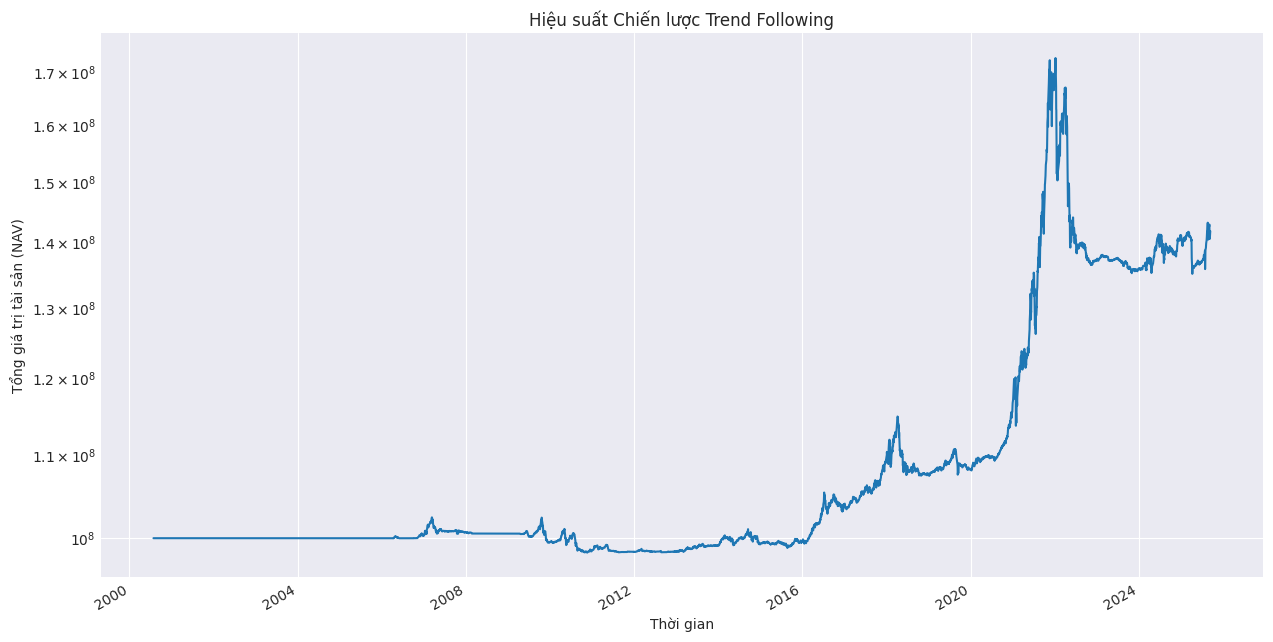

In [12]:
# In và vẽ kết quả
print("\n--- KẾT QUẢ BACKTEST ---")
print(results.tail())

# Tính toán các chỉ số hiệu suất
final_nav = results['nav'].iloc[-1]
initial_nav = config.INITIAL_CAPITAL
years = (results.index.max() - results.index.min()).days / 365.25
cagr = ((final_nav / initial_nav) ** (1 / years)) - 1

print(f"\nVốn ban đầu: {initial_nav:,.0f} VND")
print(f"NAV cuối kỳ:  {final_nav:,.0f} VND")
print(f"Thời gian:    {years:.2f} năm")
print(f"CAGR:         {cagr:.2%}")

# Vẽ biểu đồ NAV
try:
    import matplotlib.pyplot as plt
    plt.style.use('seaborn-v0_8-darkgrid')
    results['nav'].plot(figsize=(15, 8), title='Hiệu suất Chiến lược Trend Following')
    plt.ylabel('Tổng giá trị tài sản (NAV)')
    plt.xlabel('Thời gian')
    plt.yscale('log') # Dùng thang log để dễ nhìn hơn
    plt.show()
except ImportError:
    print("\nVui lòng cài đặt matplotlib (`pip install matplotlib`) để vẽ biểu đồ.")

### Stock EDA

#### Define

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Đọc tất cả file csv trong folder
def load_stock_data(folder):
    all_data = []
    for file in tqdm(os.listdir(folder)):
        if file.endswith(".csv"):
            ticker = file.replace(".csv", "")
            df = pd.read_csv(os.path.join(folder, file))
            df["time"] = pd.to_datetime(df["time"])
            df["ticker"] = ticker
            all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

# Thống kê date
def analyze_dates(df):
    stats = df.groupby("ticker").agg(min_date=("time", "min"),
                                     max_date=("time", "max")).reset_index()
    print(stats)

    plt.hist(stats["min_date"], bins=30, alpha=0.7, label="Min dates")
    plt.hist(stats["max_date"], bins=30, alpha=0.7, label="Max dates")
    plt.legend()
    plt.title("Phân phối Min/Max date của các cổ phiếu")
    plt.show()
    return stats

# Thống kê volume
def analyze_volume(df, idx=0):
    vol_stats = df.groupby("ticker")["volume"].mean().sort_values(ascending=False).reset_index()
    print(vol_stats)

    ticker = vol_stats.iloc[idx]["ticker"]
    df_ticker = df[df["ticker"] == ticker]
    
    plt.hist(df_ticker["volume"], bins=50)
    plt.title(f"Phân phối volume của {ticker}")
    plt.show()
    
    return vol_stats

def plot_volume_distribution(vol_stats):
    plt.hist(vol_stats["volume"], bins=50)
    plt.title("Phân phối mean volume của các cổ phiếu")
    plt.yscale("log")
    plt.xlabel("Mean Volume")
    plt.ylabel("Số cổ phiếu")
    plt.show()

# Thống kê giá hiện tại
def analyze_prices(df, n=10000):
    latest_prices = df.sort_values("time").groupby("ticker").tail(1)[["ticker", "close"]]
    print(latest_prices)

    count = (latest_prices["close"] <= n).sum()
    print(f"Số cổ phiếu có giá mới nhất <= {n}: {count}")
    return latest_prices, count

def compute_avg_days_per_year(df):
    """
    df: DataFrame chứa tất cả stock data, có cột 'time' và 'ticker'
    Trả về: Series trung bình số ngày có data hợp lệ cho mỗi ticker,
             và Series phân phối trung bình của toàn bộ ticker
    """
    df = df.copy()
    df["year"] = df["time"].dt.year

    results = {}

    for ticker, group in df.groupby("ticker"):
        # Xác định các năm đầy đủ để tính trung bình
        years = group["year"].unique()
        min_year, max_year = years.min(), years.max()

        # Chỉ lấy các năm đầy đủ (không tính năm đầu và cuối nếu thiếu ngày)
        valid_years = []
        yearly_counts = {}
        for y in range(min_year, max_year+1):
            year_data = group[group["year"]==y]
            # Nếu số ngày >= 250 (hoặc gần 365 ngày tùy thị trường) -> coi là đầy đủ
            if len(year_data) >= 250:  # giả sử thị trường chứng khoán ~250 ngày/năm
                valid_years.append(y)
                # Đếm số ngày không NaN trong các cột dữ liệu (bỏ cột time, ticker)
                num_days = year_data.drop(columns=["time", "ticker"]).dropna(how='all').shape[0]
                yearly_counts[y] = num_days

        if valid_years:
            # Trung bình các năm đầy đủ
            results[ticker] = np.mean([yearly_counts[y] for y in valid_years])
        else:
            results[ticker] = np.nan

    # Chuyển kết quả sang Series
    ticker_avg = pd.Series(results)
    overall_avg_distribution = ticker_avg.dropna()

    return ticker_avg, overall_avg_distribution

def analyze_nan(df: pd.DataFrame, visulize=False):
    """
    Thống kê NaN cho dữ liệu stock đã load bằng load_stock_data.
    
    Parameters:
        df (pd.DataFrame): DataFrame có cột ['time', 'open', 'high', 'low', 'close', 'volume', 'ticker']
    
    Returns:
        nan_df (pd.DataFrame): số lượng NaN cho từng mã, từng cột
        nan_mean (pd.Series): trung bình số lượng NaN trên mỗi cột
    """

    # Đếm NaN theo từng ticker
    nan_df = df.groupby("ticker").apply(lambda x: x.isna().sum())
    nan_df = nan_df[["time", "open", "high", "low", "close", "volume"]]  # giữ 6 cột chính

    # Tính trung bình NaN theo cột
    nan_mean = nan_df.mean()

    # In kết quả
    print("Số lượng NaN của mỗi mã:")
    print(nan_df)

    print("\nTrung bình số lượng NaN mỗi cột:")
    print(nan_mean)

    # Vẽ phân phối NaN cho từng cột
    if visulize:
        for col in nan_df.columns:
            plt.figure(figsize=(6,4))
            plt.hist(nan_df[col], bins=20, edgecolor="black")
            plt.title(f"Phân phối số lượng NaN - cột {col}")
            plt.xlabel("Số NaN")
            plt.ylabel("Số lượng mã")
            plt.show()

    return nan_df, nan_mean

def analyze_zero(df: pd.DataFrame, visulize=False):
    """
    Thống kê số lượng giá trị bằng 0 cho dữ liệu stock đã load bằng load_stock_data.
    
    Parameters:
        df (pd.DataFrame): DataFrame có cột ['time', 'open', 'high', 'low', 'close', 'volume', 'ticker']
    
    Returns:
        zero_df (pd.DataFrame): số lượng giá trị 0 cho từng mã, từng cột
        zero_mean (pd.Series): trung bình số lượng giá trị 0 trên mỗi cột
    """

    # Đếm số lượng 0 theo từng ticker
    zero_df = df.groupby("ticker").apply(lambda x: (x == 0).sum())
    zero_df = zero_df[["time", "open", "high", "low", "close", "volume"]]  # giữ 6 cột chính

    # Tính trung bình số lượng 0 theo cột
    zero_mean = zero_df.mean()

    # In kết quả
    print("Số lượng giá trị 0 của mỗi mã:")
    print(zero_df)

    print("\nTrung bình số lượng giá trị 0 mỗi cột:")
    print(zero_mean)

    # Vẽ phân phối số lượng 0 cho từng cột
    if visulize:
        for col in zero_df.columns:
            plt.figure(figsize=(6,4))
            plt.hist(zero_df[col], bins=20, edgecolor="black")
            plt.title(f"Phân phối số lượng 0 - cột {col}")
            plt.xlabel("Số lượng 0")
            plt.ylabel("Số lượng mã")
            plt.show()

    return zero_df, zero_mean

def check_abnormal_changes(df_all, threshold=40, vol_threshold=10_000, roll_window=42):
    """
    df_all: DataFrame chứa ['time','ticker','close','volume']
    Trả về DataFrame gồm các trường hợp pct_change bất thường
    (loại bỏ dòng đầu & cuối của mỗi ticker, 
    chỉ xác nhận bất thường nếu volume > vol_threshold 
    hoặc volume trung bình 42 ngày > vol_threshold).
    """
    df_all = df_all.copy()
    df_all["time"] = pd.to_datetime(df_all["time"])
    df_all = df_all.sort_values(["ticker", "time"])

    # % change
    df_all["pct_change"] = df_all.groupby("ticker")["close"].pct_change() * 100

    # Rolling volume mean theo ticker
    df_all["vol_roll_mean"] = (
        df_all.groupby("ticker")["volume"]
        .transform(lambda x: x.rolling(roll_window, min_periods=1).mean())
    )

    # Đánh dấu first và last row
    df_all["is_first"] = df_all.groupby("ticker").cumcount() == 0
    df_all["is_last"] = df_all.groupby("ticker").cumcount(ascending=False) == 0

    # Điều kiện volume hợp lệ
    vol_ok = (df_all["volume"] > vol_threshold) | (df_all["vol_roll_mean"] > vol_threshold)

    # Điều kiện bất thường
    abnormal = df_all[
        (
            (df_all["pct_change"].abs() > threshold)
            | (df_all["pct_change"].isna())
            | (np.isinf(df_all["pct_change"]))
        )
        & ~df_all["is_first"]
        & ~df_all["is_last"]
        & vol_ok
    ].drop(columns=["is_first", "is_last"])

    return abnormal

def check_low_high(df: pd.DataFrame):
    """
    Kiểm tra cột 'low' có phải là min và 'high' có phải là max trong [open, high, low, close].

    Parameters:
        df (pd.DataFrame): DataFrame từ hàm load_stock_data

    Returns:
        invalid_df (pd.DataFrame): Các dòng không hợp lệ
    """

    # Tính min/max trên từng dòng
    row_min = df[["open", "high", "low", "close"]].min(axis=1)
    row_max = df[["open", "high", "low", "close"]].max(axis=1)

    # Điều kiện sai
    invalid_mask = (df["low"] != row_min) | (df["high"] != row_max)
    invalid_df = df[invalid_mask]

    # In kết quả
    if invalid_df.empty:
        print("✅ Dữ liệu hợp lệ: tất cả các dòng đều có low=min và high=max.")
    else:
        print(f"⚠️ Có {len(invalid_df)} dòng dữ liệu không hợp lệ:")
        print(invalid_df[["time", "ticker", "open", "high", "low", "close"]].head(20))

    return invalid_df

def check_max_increase_from_df(all_stock_df):
    """
    all_stock_df: DataFrame đã concat từ nhiều mã, 
                  cần có cột 'ticker', 'time', 'close'
    """
    results = []

    for ticker, df in all_stock_df.groupby("ticker"):
        df = df.sort_values("time").reset_index(drop=True)
        close = df["close"].values
        time = df["time"].values

        # Skip nếu giá <=0
        if np.nanmin(close) <= 0:
            continue

        max_increase = -np.inf
        start_idx, end_idx = 0, 0

        for i in range(len(close)):
            low_price = close[i]
            future_high_idx = i + np.argmax(close[i:])
            future_high = close[future_high_idx]

            increase = (future_high - low_price) / low_price
            if increase > max_increase:
                max_increase = increase
                start_idx = i
                end_idx = future_high_idx

        if max_increase > 0:
            days = (time[end_idx] - time[start_idx]).astype('timedelta64[D]').astype(int)
            holding_years = days / 365.0  # kể cả lẻ
            CAGR = (close[end_idx] / close[start_idx]) ** (1/holding_years) - 1 if holding_years > 0 else np.nan

            results.append({
                "ticker": ticker,
                "start_date": pd.to_datetime(time[start_idx]),
                "end_date": pd.to_datetime(time[end_idx]),
                "start_price": close[start_idx],
                "end_price": close[end_idx],
                "pct_increase": max_increase,   # decimal
                "CAGR": CAGR,                   # decimal
                "holding_years": holding_years
            })
        else:
            results.append({
                "ticker": ticker,
                "start_date": np.nan,
                "end_date": np.nan,
                "start_price": np.nan,
                "end_price": np.nan,
                "pct_increase": 0,
                "CAGR": np.nan,
                "holding_years": 0
            })

    df_result = pd.DataFrame(results)

    # Lọc chỉ những mã holding > 1 tháng (~1/12 năm)
    df_filtered = df_result[df_result["holding_years"] > 1.5/12]

    # Vẽ histogram
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.hist(df_filtered["pct_increase"]*100, bins=50, color='skyblue', edgecolor='black')
    plt.title("Distribution of pct_increase (%)")
    plt.xlabel("% Increase")
    plt.ylabel("Frequency")
    plt.yscale('log')

    plt.subplot(1,2,2)
    plt.hist(df_filtered["CAGR"]*100, bins=50, color='salmon', edgecolor='black')
    plt.title("Distribution of CAGR (%)")
    plt.xlabel("CAGR %/year")
    plt.ylabel("Frequency")
    plt.yscale('log')

    plt.tight_layout()
    plt.show()

    return df_result


In [8]:
data_folder = "/mnt/c/Users/HOME/Downloads/TF-algo-trading/vci_stock_history"
df_all = load_stock_data(data_folder)
df_all_backup = df_all.copy()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1686/1686 [00:35<00:00, 47.46it/s]


#### EDA

     ticker   min_date   max_date
0       A32 2018-10-23 2025-09-08
1       AAA 2010-07-15 2025-09-12
2       AAH 2024-01-11 2025-09-12
3       AAM 2009-09-24 2025-09-12
4       AAS 2020-07-23 2025-09-12
...     ...        ...        ...
1681    XPH 2014-11-25 2025-09-12
1682    YBC 2008-05-20 2025-09-11
1683    YBM 2018-08-21 2025-09-12
1684    YEG 2018-06-26 2025-09-12
1685    YTC 2017-08-03 2025-09-11

[1686 rows x 3 columns]


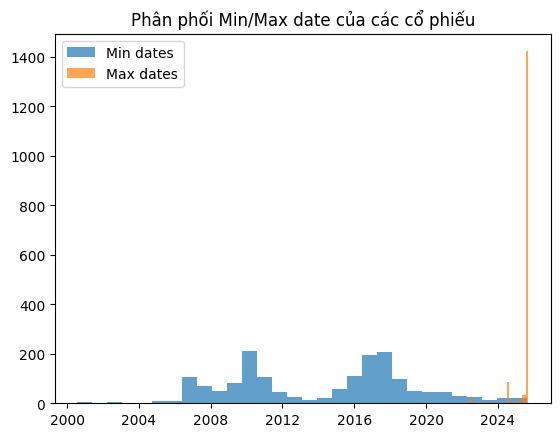

In [9]:
# Thống kê date
stats_date = analyze_dates(df_all)

     ticker        volume
0       VPB  1.177724e+07
1       SHB  1.036628e+07
2       ROS  1.010619e+07
3       HPG  8.964041e+06
4       FLC  8.864954e+06
...     ...           ...
1681    TEC  0.000000e+00
1682    SCV  0.000000e+00
1683    KTW  0.000000e+00
1684    KWA  0.000000e+00
1685    MTX  0.000000e+00

[1686 rows x 2 columns]


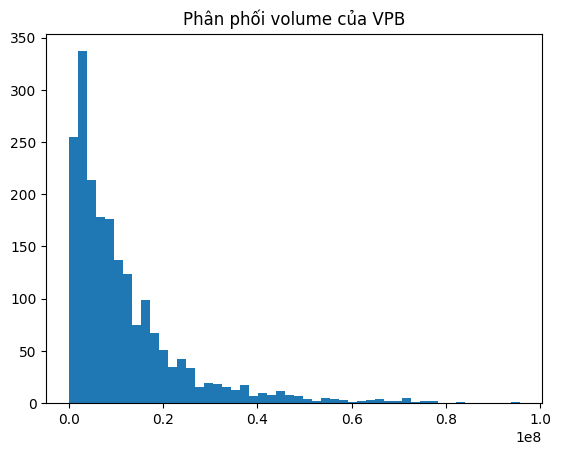

In [21]:
# Thống kê volume, ví dụ chọn idx=0 (cổ phiếu có mean volume cao nhất)
stats_volume = analyze_volume(df_all, idx=0)

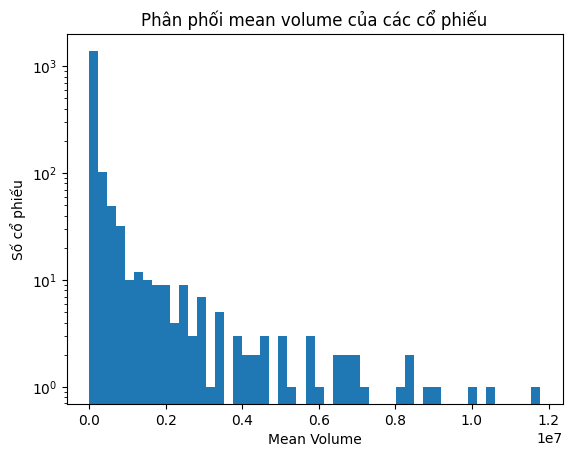

In [22]:
plot_volume_distribution(stats_volume)

In [23]:
# Thống kê giá hiện tại, ví dụ n = 20000
stats_prices, count = analyze_prices(df_all, n=10)

        ticker  close
798336     DAR   13.0
1126284    EAD   28.1
2429872    NS3    8.2
1590294    HNT    3.9
811502     DBH    7.8
...        ...    ...
1621419    HPT   28.6
2646380    PIT    6.9
3933393    TV1   23.9
1608287    HPG   30.0
1278481    GHC   30.1

[1686 rows x 2 columns]
Số cổ phiếu có giá mới nhất <= 10: 659


(array([120., 622., 727., 103.,   0.,  25.,   0.,   0.,   0.,   1.]),
 array([250. , 250.2, 250.4, 250.6, 250.8, 251. , 251.2, 251.4, 251.6,
        251.8, 252. ]),
 <BarContainer object of 10 artists>)

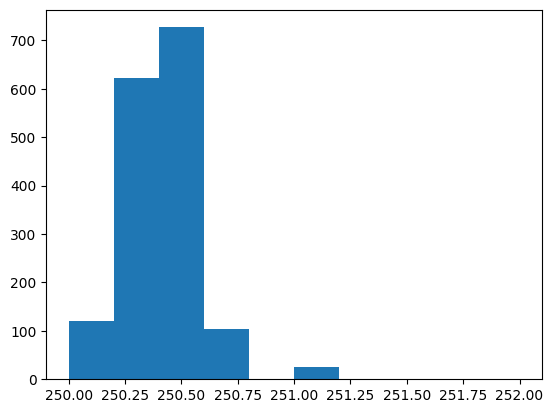

In [24]:
ticker_avg, overall_avg_distribution = compute_avg_days_per_year(df_all)
plt.hist(overall_avg_distribution)

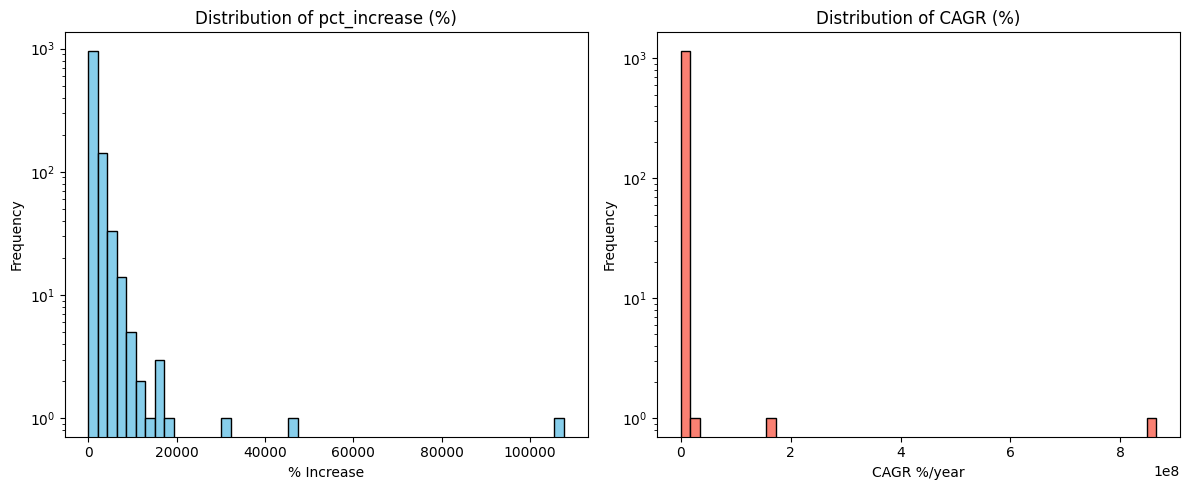

,ticker,start_date,end_date,start_price,end_price,pct_increase,CAGR,holding_years
0,AAA,2011-12-27,2022-01-07,2.33,21.89,8.394850,0.250021,10.038356
1,AAH,2024-04-23,2024-05-15,3.30,7.00,1.121212,262014.579845,0.060274
2,AAM,2016-12-29,2022-03-11,5.07,16.83,2.319527,0.259525,5.200000
3,AAS,2020-12-11,2025-08-28,3.17,23.00,6.255521,0.522424,4.715068
4,AAT,2021-03-29,2021-11-12,8.24,18.74,1.274272,2.726154,0.624658
...,...,...,...,...,...,...,...,...
1230,XMP,2021-09-30,2023-08-08,13.95,20.20,0.448029,0.220905,1.854795
1231,YBC,2017-03-13,2020-04-10,1.70,50.00,28.411765,1.998316,3.079452
1232,YBM,2020-03-30,2025-02-27,2.40,19.00,6.916667,0.523042,4.917808
1233,YEG,2022-11-15,2024-12-25,3.66,21.17,4.784153,1.295371,2.112329


In [27]:
df_increase = check_max_increase_from_df(df_all)
df_increase

#### Check values (for preprocessing)

/tmp/ipykernel_149/1251423513.py:75: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nan_df = df.groupby("ticker").apply(lambda x: x.isna().sum())


Số lượng NaN của mỗi mã:
        time  open  high  low  close  volume
ticker                                      
A32        0     0     0    0      0       0
AAA        0     0     0    0      0       0
AAH        0     0     0    0      0       0
AAM        0     0     0    0      0       0
AAS        0     0     0    0      0       0
...      ...   ...   ...  ...    ...     ...
XPH        0     0     0    0      0       0
YBC        0     0     0    0      0       0
YBM        0     0     0    0      0       0
YEG        0     0     0    0      0       0
YTC        0     0     0    0      0       0

[1686 rows x 6 columns]

Trung bình số lượng NaN mỗi cột:
time      0.000000
open      0.013049
high      0.023725
low       0.023725
close     0.025504
volume    0.139976
dtype: float64


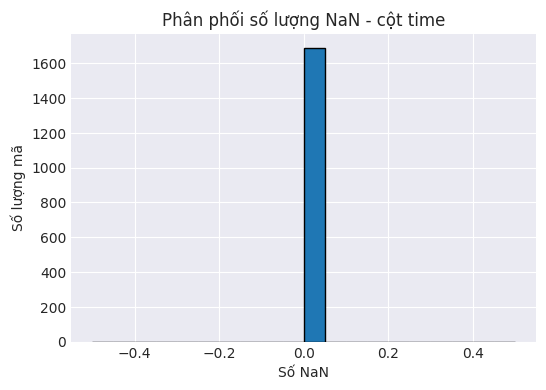

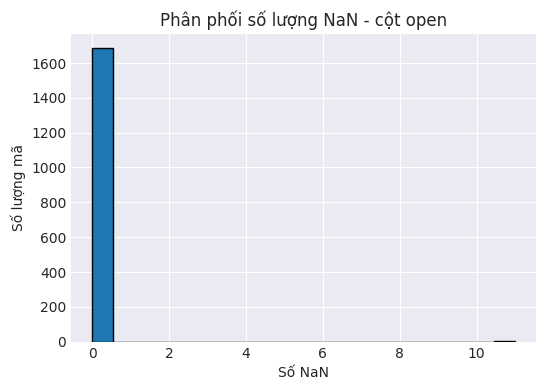

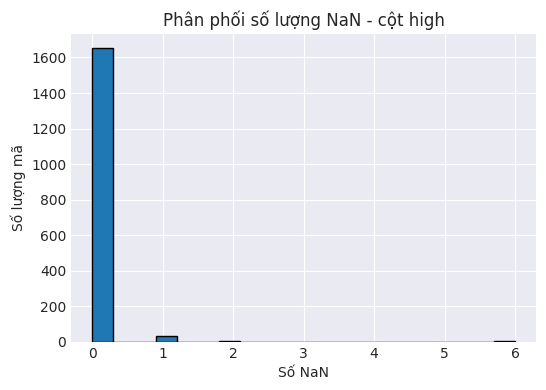

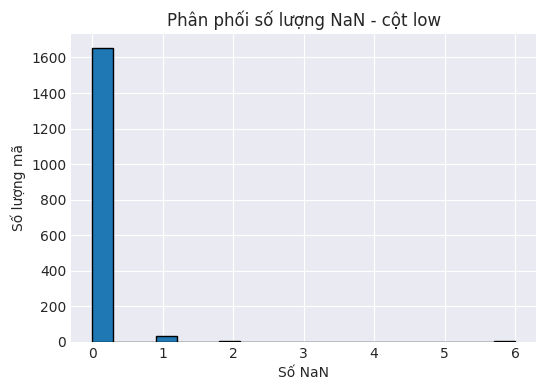

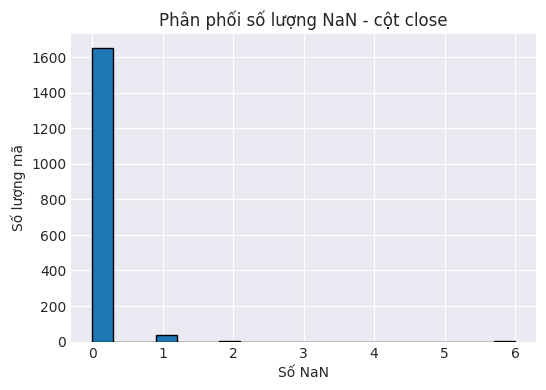

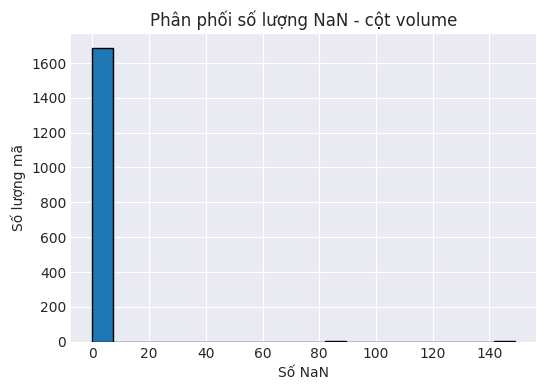

In [ ]:
nan_df, nan_mean = analyze_nan(df_all)

/tmp/ipykernel_615/1593459811.py:112: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  zero_df = df.groupby("ticker").apply(lambda x: (x == 0).sum())


Số lượng giá trị 0 của mỗi mã:
        time  open  high  low  close  volume
ticker                                      
A32        0     0     1    1      1     873
AAA        0     0     0    0      0       2
AAH        0     0     0    0      0       0
AAM        0     0     0    0      0     197
AAS        0     0     0    0      0       0
...      ...   ...   ...  ...    ...     ...
XPH        0     1     1    1      1     691
YBC        0     0     0    0      0    2421
YBM        0     0     0    0      0      30
YEG        0     0     0    0      0       0
YTC        0     0     0    0      0    1323

[1686 rows x 6 columns]

Trung bình số lượng giá trị 0 mỗi cột:
time        0.000000
open        0.680902
high        6.471530
low         6.472123
close       6.651839
volume    883.923488
dtype: float64


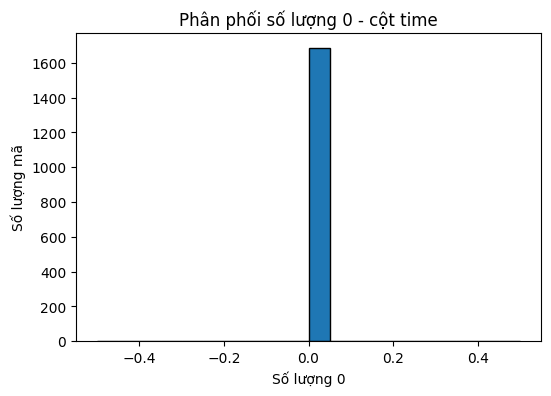

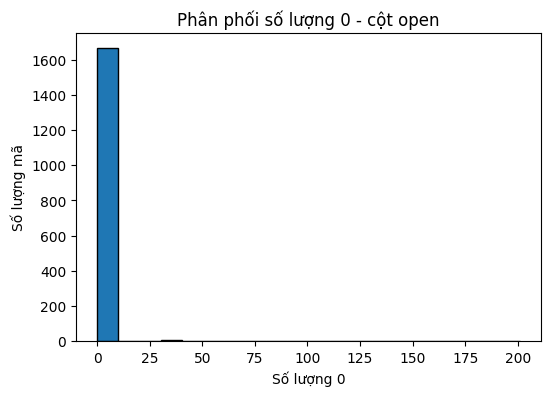

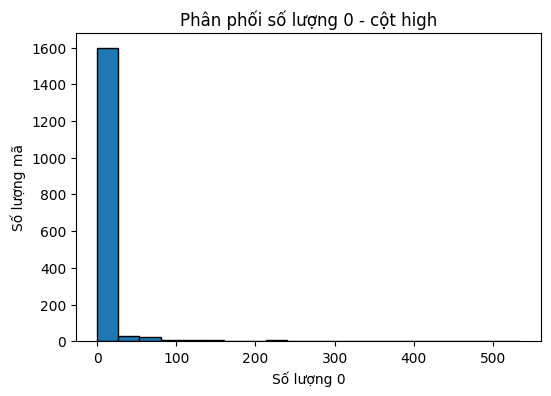

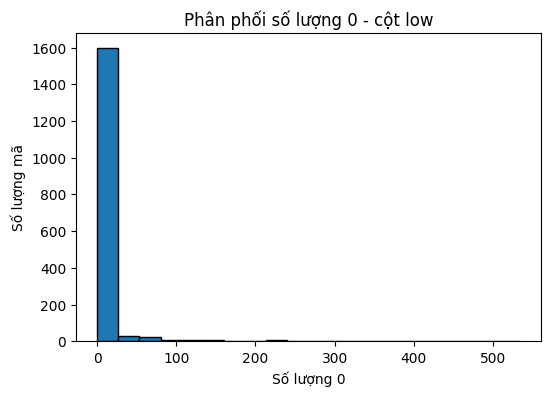

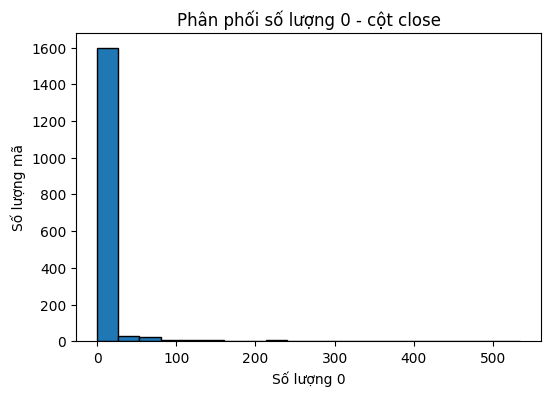

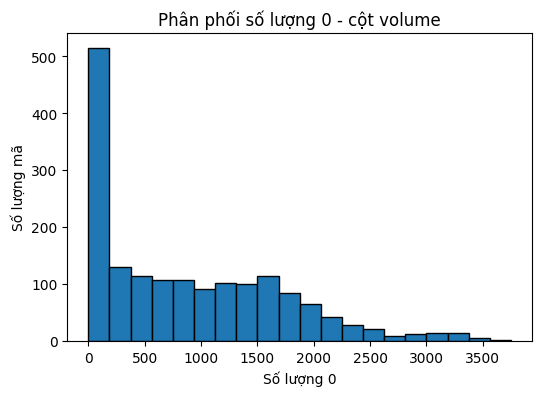

In [16]:
zero_df, zero_mean = analyze_zero(df_all)

In [ ]:
abnormal = check_abnormal_changes(processed_data)
abnormal

,time,open,high,low,close,volume,ticker,pct_change,vol_roll_mean
95837,2019-06-21,1.70,2.90,1.70,2.70,69700.0,ALV,117.741935,4603.047619
169423,2019-06-21,0.30,0.30,0.30,0.30,2104.0,ATA,50.000000,15352.071429
169448,2019-07-26,0.20,0.30,0.20,0.30,70510.0,ATA,50.000000,9340.738095
169581,2020-02-07,0.20,0.30,0.20,0.30,14340.0,ATA,50.000000,955.000000
169601,2020-03-06,0.30,0.30,0.20,0.30,24110.0,ATA,50.000000,6320.095238
...,...,...,...,...,...,...,...,...,...
4242038,2018-05-17,64.36,64.36,64.36,64.36,18000.0,VHM,268.402977,428.571429
4250714,2007-10-17,15.16,15.16,15.16,15.16,5360.0,VID,-40.150020,121617.857143
4457744,2006-07-18,7.75,7.75,7.75,7.75,0.0,VSH,46.780303,181211.904762
4508343,2024-07-30,9.50,10.30,9.50,10.00,12900.0,VTL,42.857143,2587.714286


### Preprocess

In [54]:
input_folder = '/mnt/c/Users/HOME/Downloads/TF-algo-trading/vci_stock_history'
output_folder = '/mnt/c/Users/HOME/Downloads/TF-algo-trading/processed_stock_history'
# os.makedirs(output_folder, exist_ok=True)

#### `process_stock_invalid_data`

In [55]:
# Đọc tất cả file csv
all_files = [f for f in os.listdir(input_folder) if f.endswith(".csv")]

# Tìm min và max date toàn cục
min_date, max_date = None, None
stock_dfs = {}

for file in tqdm(all_files, desc="Loading data"):
    ticker = file.replace(".csv", "")
    df = pd.read_csv(os.path.join(input_folder, file))
    df["time"] = pd.to_datetime(df["time"])
    df = df.sort_values("time").reset_index(drop=True)

    # 🚨 Kiểm tra dữ liệu có ngày T7/CN
    weekend_rows = df[df["time"].dt.weekday >= 5]
    if not weekend_rows.empty:
        print(f"[WEEKEND DATA] {ticker} có dữ liệu T7/CN, số dòng = {len(weekend_rows)}")
        print(weekend_rows[["time"]])  # in thử vài dòng đầu

    stock_dfs[ticker] = df

    # update global min/max
    if min_date is None or df["time"].min() < min_date:
        min_date = df["time"].min()
    if max_date is None or df["time"].max() > max_date:
        max_date = df["time"].max()

# Tạo dải ngày chung (Mon-Fri)
all_days = pd.date_range(start=min_date, end=max_date, freq="B")  # B = business days (Mon-Fri)

Loading data:   0%|                                                                                                                                                     | 0/1686 [00:00<?, ?it/s]

Loading data:   5%|██████▉                                                                                                                                     | 84/1686 [00:03<00:56, 28.12it/s]

[WEEKEND DATA] BBS có dữ liệu T7/CN, số dòng = 1
         time
37 2006-04-01


Loading data:  14%|███████████████████▎                                                                                                                       | 234/1686 [00:08<00:45, 31.63it/s]

[WEEKEND DATA] CID có dữ liệu T7/CN, số dòng = 8
         time
0  2005-01-08
2  2005-02-12
6  2005-05-08
10 2005-07-09
11 2005-07-10
31 2005-09-11
41 2005-10-08
62 2005-12-10


Loading data:  41%|█████████████████████████████████████████████████████████                                                                                  | 692/1686 [00:23<00:32, 30.18it/s]

[WEEKEND DATA] ILC có dữ liệu T7/CN, số dòng = 1
         time
38 2006-04-01


Loading data:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1655/1686 [01:02<00:01, 30.76it/s]

[WEEKEND DATA] VTL có dữ liệu T7/CN, số dòng = 9
          time
0   2005-01-08
2   2005-02-12
6   2005-05-08
10  2005-07-09
11  2005-07-10
31  2005-09-11
41  2005-10-08
62  2005-12-10
107 2006-04-01


Loading data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1686/1686 [01:03<00:00, 26.59it/s]


In [56]:
def process_stock_data(stock_dfs):
    processed_data = []
    out_stock_dfs = {}

    for ticker, df in tqdm(stock_dfs.items(), desc="Processing tickers"):
        df = df.copy()
        df = df.set_index("time")
        # min_t, max_t = df["time"].min(), df["time"].max()
        # df = df.set_index("time")

        # date_range = pd.date_range(start=min_t, end=max_t)
        # df = df.reindex(date_range)

        # --- 1. Đánh dấu invalid ---
        invalid_open  = df["open"].isna()  | (df["open"]  <= 0)
        invalid_high  = df["high"].isna()  | (df["high"]  <= 0)
        invalid_low   = df["low"].isna()   | (df["low"]   <= 0)
        invalid_close = df["close"].isna() | (df["close"] <= 0)
        invalid_vol   = df["volume"].isna() | (df["volume"] < 0)

        # --- 2. Case 4 giá trị invalid: fill close ffill/bfill ---
        all_invalid = invalid_open & invalid_high & invalid_low & invalid_close
        valid_close = df["close"].where((df["close"] > 0) & df["close"].notna())
        df.loc[all_invalid, "close"] = valid_close.ffill().bfill()
        df.loc[all_invalid, ["open", "high", "low"]] = df.loc[all_invalid, "close"]

        # update
        invalid_open  = df["open"].isna()  | (df["open"]  <= 0)
        invalid_high  = df["high"].isna()  | (df["high"]  <= 0)
        invalid_low   = df["low"].isna()   | (df["low"]   <= 0)
        invalid_close = df["close"].isna() | (df["close"] <= 0)

        # --- 3. Ưu tiên high/low ---
        # low = min(open, high, close) nếu invalid
        cols = ["open", "high", "close"]
        tmp = df.loc[invalid_low, cols].replace(0, np.nan)  # thay 0 bằng NaN
        tmp[tmp <= 0] = np.nan  # bỏ cả giá trị <=0

        df.loc[invalid_low, "low"] = tmp.min(axis=1)
        # high = max(open, low, close) nếu invalid
        df.loc[invalid_high, "high"] = df.loc[invalid_high, ["open", "low", "close"]].max(axis=1)

        # update
        invalid_high  = df["high"].isna()  | (df["high"]  <= 0)
        invalid_low   = df["low"].isna()   | (df["low"]   <= 0)

        # --- 4. Ưu tiên close ---
        # close = open -> low -> high (theo thứ tự)
        df.loc[invalid_close, "close"] = (
            df["open"].where(~invalid_open)
            .fillna(df["low"].where(~invalid_low))
            .fillna(df["high"].where(~invalid_high))
            .fillna(df["close"])
        )

        # update
        invalid_close  = df["close"].isna()  | (df["close"]  <= 0)

        # --- 5. Ưu tiên open ---
        # open = close -> low -> high (theo thứ tự)
        df.loc[invalid_open, "open"] = (
            df["close"].where(~invalid_close)
            .fillna(df["low"].where(~invalid_low))
            .fillna(df["high"].where(~invalid_high))
            .fillna(df["open"])
        )

        # --- 6. Volume ---
        valid_vol = df["volume"].where((df["volume"] >= 0) & df["volume"].notna())
        df.loc[invalid_vol, "volume"] = valid_vol.ffill().bfill()

        # Reset index
        df = df.reset_index().rename(columns={"index": "time"})
        df["ticker"] = ticker
        processed_data.append(df)
        out_stock_dfs[ticker] = df

    all_processed = pd.concat(processed_data, ignore_index=True)
    print("✅ Done processing all tickers!")
    return all_processed, out_stock_dfs

processed_data, out_stock_dfs = process_stock_data(stock_dfs)

Processing tickers: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1686/1686 [00:57<00:00, 29.31it/s]


✅ Done processing all tickers!


In [57]:
analyze_nan(processed_data)

Số lượng NaN của mỗi mã:
        time  open  high  low  close  volume
ticker                                      
A32        0     0     0    0      0       0
AAA        0     0     0    0      0       0
AAH        0     0     0    0      0       0
AAM        0     0     0    0      0       0
AAS        0     0     0    0      0       0
...      ...   ...   ...  ...    ...     ...
XPH        0     0     0    0      0       0
YBC        0     0     0    0      0       0
YBM        0     0     0    0      0       0
YEG        0     0     0    0      0       0
YTC        0     0     0    0      0       0

[1686 rows x 6 columns]

Trung bình số lượng NaN mỗi cột:
time      0.0
open      0.0
high      0.0
low       0.0
close     0.0
volume    0.0
dtype: float64


/tmp/ipykernel_809/284803357.py:116: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nan_df = df.groupby("ticker").apply(lambda x: x.isna().sum())


(        time  open  high  low  close  volume
 ticker                                      
 A32        0     0     0    0      0       0
 AAA        0     0     0    0      0       0
 AAH        0     0     0    0      0       0
 AAM        0     0     0    0      0       0
 AAS        0     0     0    0      0       0
 ...      ...   ...   ...  ...    ...     ...
 XPH        0     0     0    0      0       0
 YBC        0     0     0    0      0       0
 YBM        0     0     0    0      0       0
 YEG        0     0     0    0      0       0
 YTC        0     0     0    0      0       0
 
 [1686 rows x 6 columns],
 time      0.0
 open      0.0
 high      0.0
 low       0.0
 close     0.0
 volume    0.0
 dtype: float64)

In [58]:
analyze_zero(processed_data)

Số lượng giá trị 0 của mỗi mã:
        time  open  high  low  close  volume
ticker                                      
A32        0     0     0    0      0     873
AAA        0     0     0    0      0       2
AAH        0     0     0    0      0       0
AAM        0     0     0    0      0     197
AAS        0     0     0    0      0       0
...      ...   ...   ...  ...    ...     ...
XPH        0     0     0    0      0     691
YBC        0     0     0    0      0    2421
YBM        0     0     0    0      0      30
YEG        0     0     0    0      0       0
YTC        0     0     0    0      0    1323

[1686 rows x 6 columns]

Trung bình số lượng giá trị 0 mỗi cột:
time        0.000000
open        0.000000
high        0.000000
low         0.000000
close       0.000000
volume    884.011862
dtype: float64


/tmp/ipykernel_809/284803357.py:154: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  zero_df = df.groupby("ticker").apply(lambda x: (x == 0).sum())


(        time  open  high  low  close  volume
 ticker                                      
 A32        0     0     0    0      0     873
 AAA        0     0     0    0      0       2
 AAH        0     0     0    0      0       0
 AAM        0     0     0    0      0     197
 AAS        0     0     0    0      0       0
 ...      ...   ...   ...  ...    ...     ...
 XPH        0     0     0    0      0     691
 YBC        0     0     0    0      0    2421
 YBM        0     0     0    0      0      30
 YEG        0     0     0    0      0       0
 YTC        0     0     0    0      0    1323
 
 [1686 rows x 6 columns],
 time        0.000000
 open        0.000000
 high        0.000000
 low         0.000000
 close       0.000000
 volume    884.011862
 dtype: float64)

In [59]:
def invalid_filling_check(stock_dfs, out_stock_dfs):
    # Các cột cần xét
    cols_to_check = ["low", "high", "open", "close", "volume"]

    # Hàm kiểm tra giá trị hợp lệ
    def is_valid(col_name, series):
        if col_name in ["low", "high", "open", "close"]:
            return (series > 0) & series.notna()
        elif col_name == "volume":
            return (series >= 0) & series.notna()
        else:
            return pd.Series([True] * len(series))

    # Lưu kết quả fill dư / fill thiếu
    results = {}

    for ticker in stock_dfs.keys():
        df_orig = stock_dfs[ticker]
        df_filled = out_stock_dfs[ticker]
        
        results[ticker] = {}
        
        for col in cols_to_check:
            valid_mask = is_valid(col, df_orig[col])
            invalid_mask = ~valid_mask
            
            # Fill dư: vị trí hợp lệ nhưng đã bị thay đổi
            overfill_mask = valid_mask & (df_orig[col] != df_filled[col])
            overfill_ratio = overfill_mask.sum() / len(df_orig[col])
            
            # Fill thiếu: vị trí invalid nhưng chưa được fill
            underfill_mask = invalid_mask & (df_filled[col] == df_orig[col])
            underfill_ratio = underfill_mask.sum() / len(df_orig[col])
            
            results[ticker][col] = {
                "overfill_ratio": overfill_ratio,
                "underfill_ratio": underfill_ratio
            }

    # Tính mean theo cột
    overfill_means = {col: [] for col in cols_to_check}
    underfill_means = {col: [] for col in cols_to_check}

    for ticker, col_dict in results.items():
        for col in cols_to_check:
            overfill_means[col].append(col_dict[col]["overfill_ratio"])
            underfill_means[col].append(col_dict[col]["underfill_ratio"])

    mean_overfill = {col: np.nanmean(overfill_means[col]) for col in cols_to_check}
    mean_underfill = {col: np.nanmean(underfill_means[col]) for col in cols_to_check}

    return pd.DataFrame({
        "mean_overfill": mean_overfill,
        "mean_underfill": mean_underfill
    })

invalid_filling_check(stock_dfs, out_stock_dfs)

,mean_overfill,mean_underfill
low,0.0,0.0
high,0.0,0.0
open,0.0,0.0
close,0.0,0.0
volume,0.0,0.0


In [ ]:
def get_window(stock_dfs, ticker, date_n, window=5):
    """
    Lấy dữ liệu stock từ ticker tại ngày date_n ± window ngày.
    
    stock_dfs: dict[ticker -> DataFrame]
    ticker: mã cổ phiếu
    date_n: ngày cần lấy (datetime hoặc str)
    window: số ngày trước/sau (mặc định 5)
    """
    df = stock_dfs[ticker].copy()
    df["time"] = pd.to_datetime(df["time"])
    date_n = pd.to_datetime(date_n)
    
    start_date = date_n - pd.Timedelta(days=window)
    end_date = date_n + pd.Timedelta(days=window)
    
    mask = (df["time"] >= start_date) & (df["time"] <= end_date)
    return df.loc[mask].sort_values("time").reset_index(drop=True)

# Ví dụ
ticker = "VGS"
date_n = "2008-12-17"
window_df = get_window(stock_dfs, ticker, date_n, window=5)
print(window_df)

        time  open  high   low  close  volume
0 2008-12-12  3.63  3.89  3.63   3.63  201500
1 2008-12-15  3.74  3.89  3.59   3.85  150200
2 2008-12-16  3.89  3.89  3.63   3.76  120400
3 2008-12-17  2.18  2.22  2.18   2.22  538100
4 2008-12-18  2.37  2.37  2.35   2.37  190500
5 2008-12-19  2.52  2.52  2.44   2.52  441100
6 2008-12-22  2.67  2.67  2.50   2.52  179200


In [64]:
def save_processed_stocks(out_stock_dfs, output_folder="processed_stock_history"):
    os.makedirs(output_folder, exist_ok=True)  # tạo folder nếu chưa có
    
    for ticker, df in tqdm(out_stock_dfs.items(), desc="Saving processed stocks"):
        # đảm bảo cột time được lưu đúng format
        df = df.copy()
        df["time"] = pd.to_datetime(df["time"])
        
        out_path = os.path.join(output_folder, f"{ticker}.csv")
        df.to_csv(out_path, index=False)
    
    print(f"✅ Saved {len(out_stock_dfs)} tickers into folder: {output_folder}")

# Gọi hàm
save_processed_stocks(out_stock_dfs, output_folder)

Saving processed stocks:   0%|                                                                                                                                          | 0/1686 [00:00<?, ?it/s]

Saving processed stocks: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1686/1686 [03:00<00:00,  9.37it/s]

✅ Saved 1686 tickers into folder: /mnt/c/Users/HOME/Downloads/TF-algo-trading/processed_stock_history
